<a href="https://colab.research.google.com/github/iremcetin/Attention_generation/blob/main/%5Bv2%5DEmidec_seResNet50_w_clinic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q monai
!pip install tqdm
!pip install nibabel
!pip install scikit-learn
!pip install pyradiomics

     |████████████████████████████████| 358kB 16.9MB/s 
     |████████████████████████████████| 194kB 18.1MB/s 
     |████████████████████████████████| 47.4MB 59kB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 552kB 48.5MB/s 


In [ ]:
# Imports for Radiomics
import SimpleITK as sitk
import six

import radiomics

In [ ]:
from collections import Counter
import cv2
import pandas as pd

In [ ]:
import os
import glob
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tempfile
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import monai
#from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChannel, Compose, LoadImage, RandRotate90, NormalizeIntensity, RandScaleIntensity,
    Resize, ScaleIntensityRange, ToTensor, ScaleIntensity, RandShiftIntensity,CropForeground,
    RandFlip, RandSpatialCrop, ResizeWithPadOrCrop, Spacing, ThresholdIntensity, Orientation
)
from monai.metrics import compute_roc_auc
monai.config.print_config()
random_seed = 42
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.4.0
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
doyouhavecroppedfiles = True # if you already cropped/preprocessed files set this True o.w. False

In [ ]:
num_class = 2 # enter the number of classes in the dataset

***Transfer the dataset (Emidec)*** - from google drive

In [ ]:
# Give permission to google drive 
# Generated files will be saved there

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
training_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training"  

***Helper Functions***

In [ ]:
# Overlay Original image and GradCAM heatmap
def superimposed_image_def(cam_img, original_img, alpha = 0.6):
    original_img = original_img[0,0,:,:] # If you use different image check here and change

    # Make 1-channel image to 3-channel : To overlay this image with the heatmap (JET colormap = 3-channels)
    original_img = cv2.merge((original_img, original_img, original_img))
    cam_img = cam_img[0,0,:,:] # Same above
    
    cam_img = np.maximum(cam_img, 0)

    # Convert Class Activation Map to 0 - 255
    cam_img = (cam_img - cam_img.min()) / (
               cam_img.max() - cam_img.min()
    )
    cam_img = np.uint8(255 * cam_img)

    # Convert to Heatmap ---- JET COLORMAP
    cam_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    #cvt_heatmap = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

    superimposed_image =np.uint8(np.uint8(original_img) * alpha + cam_img * (1 - alpha))
    #superimposed_image = cv2.addWeighted(original_img, (1-alpha), cam_img, alpha, 0)
    return superimposed_image

In [ ]:
#Find the maximum in the shapes of the patches and check them with the gt patches :This part is to check max dimensions of each coordinate.
def find_max_dim(shape_img, shape_gt):
    res1 = max(shape_img, key = lambda i : i[0])[0]
    res2 = max(shape_img, key = lambda i : i[1])[1]
    res3 = max(shape_img, key = lambda i : i[2])[2]
    print("Maximum image dimensions, dim1: %d, dim2: %d, dim3: %d"%(res1, res2, res3))
    res4 = max(shape_gt, key = lambda i : i[0])[0]
    res5 = max(shape_gt, key = lambda i : i[1])[1]
    res6 = max(shape_gt, key = lambda i : i[2])[2]
    print("Maximum GT dimensions, dim1: %d, dim2: %d, dim3: %d"%(res4, res5, res6)) # These dimensions must be the same as image patches (res1, res2 and res3)

    return

In [ ]:
def mask_operations(mask, patient_id, path_binmask):
    ##### Note : Mask is not binarize --> You need to binarize it
    ##### Step 1 : Binary threshold 
#    mask_array = sitk.GetArrayFromImage(mask)
    btif=sitk.BinaryThresholdImageFilter()
    btif.SetLowerThreshold(0) # lower value to set as background = 0 : Inside value
    btif.SetUpperThreshold(1) # upper value, if you set 2: label 3 will be visible, if you set 1, label 2 and 3 visible 
    btif.SetInsideValue(0)
    btif.SetOutsideValue(1)
    mask = btif.Execute(mask)
    ##### Step 2 : Morphological closing --> fill the pixels with 0 inside ROI with 1 (fill the holes inside the ROI)
    closing = sitk.BinaryMorphologicalClosingImageFilter()
    
    mask =closing.Execute(mask)
#    binMask = sitk.GetArrayFromImage(mask) ### To check the mask's pixel values
    
    ### save image to check later
    binmask_path = path_binmask + patient_id + '_binMask.nii.gz'
    sitk.WriteImage(mask, binmask_path)
    
    
    return mask

In [ ]:
def nii_reader(path):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(path)
    img = reader.Execute();
    return img

In [ ]:
def create_patches(path, patient):
     
    # Define the image paths [images and masks]
    img_path=os.path.join(path,"Images","%s.nii.gz" %(patient)) # Directory of image nii
    gt_path =os.path.join(path, "Contours","%s.nii.gz" %(patient)) # Directory of Ground truth

    print(f"Image path {img_path}")
    # Load the images with sitk
    img = nii_reader(img_path)
    gt_img = nii_reader(gt_path)

    # mask operations
    # Combine 2 labels together
    binMask_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/binMask/"
    gt_img_l1 = mask_operations(gt_img, patient, binMask_path)  # make the segmentation 1-layer only
    

    # ED
    (bbox, corrected_mask) = radiomics.imageoperations.checkMask(img, gt_img_l1, correctMask=True )
    (cropped_img, cropped_gt) = radiomics.imageoperations.cropToTumorMask(img, gt_img_l1, boundingBox=bbox)
    (cropped_gt_scar, a) = radiomics.imageoperations.cropToTumorMask(gt_img, gt_img_l1, boundingBox=bbox )
    return cropped_img, cropped_gt, cropped_gt_scar

In [ ]:
def preprocess_files(path_training, minf_cohort, cohort_name):
    patient_ids=[] 
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[] 
    segs_scar =[]
    shape_img=[] 
    shape_gt = []

    save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX


    for j in range(len(minf_cohort)):
          path_files = os.path.join(path_training, minf_cohort[j] )
          patient_id = minf_cohort[j]
 
          print('%s with %s'%(patient_id, cohort_name))  

          [cropped_img, cropped_gt, cropped_gt_scar] = create_patches(path_files, patient_id)

          # ED
          cropped_arr =  sitk.GetArrayFromImage(cropped_img)
          cropped_gt_arr = sitk.GetArrayFromImage(cropped_gt)


          # multiply mask and ground truth to remove LV blood pool from the image = only for EMIDEC dataset
          multiply = sitk.MultiplyImageFilter()
          cropped_gt_casted = sitk.Cast(cropped_gt, sitk.sitkFloat64)
          
          new_img = multiply.Execute(cropped_img, cropped_gt_casted)
          
          new_img_arr = sitk.GetArrayFromImage(new_img)
          ############################

          # Multiply scar segmentation with 1-label segmentation = Removes LV Blood pool from the segmentation 
          # This part is for visualization purposes
          

          filename_img = os.path.join(save_path,"%s.nii.gz" %(patient_id))
          filename_gt = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
          #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
          filename_gt_scar = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
          images.append(filename_img)
          segs.append(filename_gt)
          segs_scar.append(filename_gt_scar)

          sitk.WriteImage(new_img, filename_img)
          #sitk.WriteImage(cropped_img, filename_img_org)
          sitk.WriteImage(cropped_gt, filename_gt)

          sitk.WriteImage(cropped_gt_scar, filename_gt_scar)
          #shape_img.append(cropped_arr.shape)
          shape_img.append(new_img_arr.shape)
          shape_gt.append(cropped_gt_arr.shape)

          if cohort_name =="MINF":
                    value = 1
          else: 
                value = 0
          
          Label.append(value)
          patient_ids.append(patient_id)


    return images, segs, Label, shape_img, shape_gt

In [ ]:
# read the files
# load the variables
# If the files already cropped, you only need to load the images.

def load_preprocessed_files(path_training, minf_cohort, cohort_name):
    patient_ids=[] 
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[] 
    segs_scar =[]
    shape_img=[] 
    shape_gt = []

    save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX


    for j in range(len(minf_cohort)):
          path_files = os.path.join(path_training, minf_cohort[j] )
          patient_id = minf_cohort[j]
 
          print('%s with %s'%(patient_id, cohort_name))  

         
          filename_img_path = os.path.join(save_path,"%s.nii.gz" %(patient_id))
          filename_gt_path = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
          #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
          filename_gt_scar_path = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
          images.append(filename_img_path)
          segs.append(filename_gt_path)
          segs_scar.append(filename_gt_scar_path)

          filename_img = nii_reader(filename_img_path)
          filename_gt = nii_reader(filename_gt_path)
          filename_scar = nii_reader(filename_gt_scar_path)
      
          
          filename_img_arr = sitk.GetArrayFromImage(filename_img)
          gt_shape = sitk.GetArrayFromImage(filename_gt)
          scar_shape = sitk.GetArrayFromImage(filename_scar)

          shape_img.append(filename_img_arr.shape)
          shape_gt.append(gt_shape.shape)
          ####################################
          if cohort_name =="MINF":
                    value = 1
          else: 
                value = 0
          
          Label.append(value)
          patient_ids.append(patient_id)


    return images, segs, Label, shape_img, shape_gt

# **DATA PREPARATION**

In [ ]:
path_files = os.listdir(training_path)
import glob
info_files = [f for f in os.listdir(training_path) if f.endswith('.txt')] # these are info files
info_files.sort()
folders =  [f for f in os.listdir(training_path) if not f.endswith('.txt')]# the others are the patient folders
folders.sort()

In [ ]:
emidec_columns = ["GBS", "SEX", "AGE", "TOBACCO", "OVERWEIGHT", "ART_HYPERT", "DIABETES", "FHCAD", "ECG", "TROPONIN", "KILLIP", "FEVG", "NTProNBP"]


def load_clinical_info(path, info_files, emidec_columns, folders):
    clinical_info = pd.DataFrame(index=folders, columns=emidec_columns)
    for i in range(len(info_files)):

        Info_path=os.path.join(path,info_files[i])

        with open(Info_path, 'r', encoding='mac_roman') as Info : 
             line = Info.readlines()
             for j in range(2, len(emidec_columns)+2):   
                 if j == 2:
                    clinical_info.iloc[i,j-2] = line[j].rstrip().split(":")[1][:3]
                 else:
                    clinical_info.iloc[i,j-2] = line[j].rstrip().split(":")[1]   


    return clinical_info
                
clinical_info_training = load_clinical_info(training_path, info_files, emidec_columns, folders)

In [ ]:
clinical_info_training.iloc[40:50]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_P009,8,F,60,3,N,Y,N,N,Y,120,1,50,135
Case_P010,10,M,68,2,Y,Y,N,N,Y,83,4,60,42
Case_P011,10,M,79,2,Y,Y,N,N,Y,39,1,60,2270
Case_P015,10,M,56,1,Y,Y,N,N,Y,410,1,40,571
Case_P017,10,M,75,2,N,Y,Y,N,N,88,1,50,2871
Case_P019,10,M,52,1,Y,N,N,N,N,87,3,20,7139
Case_P021,10,M,29,3,Y,N,N,N,Y,33,1,60,37
Case_P022,10,M,53,1,N,N,N,N,Y,170,1,60,43
Case_P026,10,M,38,1,Y,N,N,N,N,6.3,1,64,38
Case_P028,10,M,61,2,Y,N,N,N,Y,180,2,25,2213


In [ ]:
# Preprocess the values
cleanup_nums = {"SEX":     {" F": 1, " M": 0},
                "OVERWEIGHT": {" N": 0, " Y": 1},
                "ART_HYPERT": {" N": 0, "N":0, " Y": 1},
                "DIABETES": {" N": 0, " Y": 1},
                "FHCAD" : {" N": 0, " Y": 1},
                "ECG" : {" N": 0, " Y": 1}}


clinical_info_training = clinical_info_training.replace(cleanup_nums)

In [ ]:
clinical_info_training.iloc[80:90]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_P077,13,1,67,3,1,0,0,0,1,220,1,55,78
Case_P078,13,0,73,1,0,0,0,0,1,190,1,30,1268
Case_P080,8,0,57,1,0,0,0,0,1,26,1,55,65
Case_P081,13,0,67,1,0,0,0,0,1,110,1,55,47
Case_P082,10,0,56,1,1,0,0,0,1,0.9,1,45,1143
Case_P085,10,1,63,3,0,1,0,1,0,5.2,1,68,1690
Case_P086,10,0,64,1,1,0,0,0,1,13,2,25,3711
Case_P087,10,1,62,3,0,1,0,0,1,5.2,1,47,2989
Case_P088,13,0,60,1,0,0,0,0,1,100,1,65,110
Case_P090,10,1,54,3,0,1,0,0,1,170,1,45,68


In [ ]:
#folders[0].split("_")[1]

healthy_cohort =  [param for param in folders if param.split("_")[1].startswith('N')] # the ones start with N (after _) are healthy
minf_cohort = [param for param in folders if param.split("_")[1].startswith('P')] # the ones start with P are MINF
nb_healthy =  len(healthy_cohort)
nb_minf = len(minf_cohort)

In [ ]:
print(f"There are {nb_healthy} healthy and {nb_minf} heart attack patients in the dataset.")

There are 33 healthy and 67 heart attack patients in the dataset.


In [ ]:
if doyouhavecroppedfiles == True: 
    images_minf, segs_minf, Label_minf, shape_img_minf, shape_gt_minf  = load_preprocessed_files(training_path, minf_cohort, cohort_name='MINF')
    images_nor, segs_nor, Label_nor,  shape_img_nor, shape_gt_nor  = load_preprocessed_files(training_path, healthy_cohort, cohort_name='NOR')
else:
    images_minf, segs_minf, Label_minf, shape_img_minf, shape_gt_minf = preprocess_files(training_path, minf_cohort, cohort_name='MINF')
    images_nor, segs_nor, Label_nor, shape_img_nor, shape_gt_nor = preprocess_files(training_path, healthy_cohort, cohort_name='NOR')


Case_P001 with MINF
Case_P002 with MINF
Case_P003 with MINF
Case_P004 with MINF
Case_P005 with MINF
Case_P007 with MINF
Case_P008 with MINF
Case_P009 with MINF
Case_P010 with MINF
Case_P011 with MINF
Case_P015 with MINF
Case_P017 with MINF
Case_P019 with MINF
Case_P021 with MINF
Case_P022 with MINF
Case_P026 with MINF
Case_P028 with MINF
Case_P029 with MINF
Case_P031 with MINF
Case_P035 with MINF
Case_P036 with MINF
Case_P038 with MINF
Case_P039 with MINF
Case_P043 with MINF
Case_P044 with MINF
Case_P045 with MINF
Case_P047 with MINF
Case_P050 with MINF
Case_P051 with MINF
Case_P053 with MINF
Case_P055 with MINF
Case_P056 with MINF
Case_P057 with MINF
Case_P059 with MINF
Case_P060 with MINF
Case_P061 with MINF
Case_P062 with MINF
Case_P063 with MINF
Case_P064 with MINF
Case_P066 with MINF
Case_P067 with MINF
Case_P069 with MINF
Case_P071 with MINF
Case_P072 with MINF
Case_P073 with MINF
Case_P074 with MINF
Case_P076 with MINF
Case_P077 with MINF
Case_P078 with MINF
Case_P080 with MINF


In [ ]:
find_max_dim(shape_img_minf, shape_gt_minf)

Maximum image dimensions, dim1: 10, dim2: 61, dim3: 59
Maximum GT dimensions, dim1: 10, dim2: 61, dim3: 59


In [ ]:
images = [*images_nor, *images_minf ,]
Label = [*Label_nor, *Label_minf]

In [ ]:
#make Label to one-hot-vector
n_values = np.max(Label) + 1
Label_1h = np.eye(n_values)[Label]

In [ ]:
indices =np.arange(clinical_info_training.shape[0])

In [ ]:
clinical_info_training[:5]

,GBS,SEX,AGE,TOBACCO,OVERWEIGHT,ART_HYPERT,DIABETES,FHCAD,ECG,TROPONIN,KILLIP,FEVG,NTProNBP
Case_N006,10,1,70,3,0,1,0,0,1,1.1,1,60,248
Case_N012,10,0,33,3,1,0,0,0,0,2.8,1,60,89
Case_N013,10,1,40,1,0,0,0,0,0,0.35,1,60,1133
Case_N014,10,0,66,2,1,1,1,0,0,2.7,1,55,78
Case_N016,13,0,76,1,1,0,0,0,1,14,1,60,192


In [ ]:
images[:5]

['/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N006.nii.gz',
 '/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N012.nii.gz',
 '/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N013.nii.gz',
 '/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N014.nii.gz',
 '/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N016.nii.gz']

In [ ]:
#Define the Images and the Labels - ED & ES - Dictionary definition
#all_files = [{"image": img, "label": label} for img, label in zip(images_minf+images_nor, Label_minf+Label_nor)]
#random.shuffle(all_files)
#print(f"total items: {len(all_files)}")


train_files, val_files, train_labels,  val_labels, indices_train, indices_val, clinical_info_train, clinical_info_val = train_test_split(images, Label, indices, clinical_info_training.values,  test_size=0.33, random_state=42)

***Check the indices for Training and Testing dataset***

In [ ]:
indices_train

array([28, 93,  5, 66, 65, 35, 16, 49, 34,  7, 95, 27, 19, 81, 25, 62, 13,
       24,  3, 17, 38,  8, 78,  6, 64, 36, 89, 56, 99, 54, 43, 50, 67, 46,
       68, 61, 97, 79, 41, 58, 48, 98, 57, 75, 32, 94, 59, 63, 84, 37, 29,
        1, 52, 21,  2, 23, 87, 91, 74, 86, 82, 20, 60, 71, 14, 92, 51])

In [ ]:
train_files[0]

'/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N075.nii.gz'

In [ ]:
images[indices_train[0]]

'/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_N075.nii.gz'

In [ ]:
clinical_info_train = [[np.float32(y) for y in x] for x in clinical_info_train]
clinical_info_val = [[np.float32(y) for y in x] for x in clinical_info_val]

***Preprocess the clinical features***

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clinical_info_train_scl = scaler.fit_transform(clinical_info_train)
clinical_info_val_scl = scaler.transform(clinical_info_val)

In [ ]:
type(clinical_info_train[2][2])


numpy.float32

In [ ]:
#all_files[78]["image"]
print(f"File name -random- in training dataset: {train_files[33]}")
print(f"Label name -random- in training dataset: {train_labels[33]}")


File name -random- in training dataset: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P021.nii.gz
Label name -random- in training dataset: 1


In [ ]:
print(f"Total number of training cases: {len(train_files)}")
print(f"Total number of validation cases: {len(val_files)}")

Total number of training cases: 67
Total number of validation cases: 33


In [ ]:
# Define transforms for image
win_size = (112, 112, 16)  # CHECK 
train_transforms = Compose(
    [
        LoadImage(image_only = True),
        AddChannel(),       
        #Orientation(axcodes="RAS"),
        
        #CropForeground(),
        NormalizeIntensity(nonzero=False, channel_wise=True),
        
        Resize(win_size,"trilinear"),
        
        #ThresholdIntensity(threshold=1.1),
      #  ScaleIntensity(),             
        ToTensor(),
    ]
)
val_transforms = Compose(
    [
        LoadImage(image_only = True),
        AddChannel(),
        #Orientation(axcodes="RAS"),
        
        #CropForeground(),
        NormalizeIntensity(nonzero=False, channel_wise=True),
        
        Resize(win_size,"trilinear"),
        
        #ThresholdIntensity(threshold=1.1),
       # ScaleIntensity(),
        ToTensor(),
    ]
)

visualize_transforms = Compose(
    [
        LoadImage(image_only = True),
        AddChannel(),
        Resize(win_size,"trilinear"),
       
        #ResizeWithPadOrCrop(win_size),
        ThresholdIntensity(threshold=1.1),
        ToTensor(),
    ]
)


In [ ]:
#Check images
case_id = 20 # enter the id of the file that you want to visualize
loader = LoadImage()
img_loaded = loader(train_files[case_id])
print(f"Case: {train_files[case_id]}")




Case: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P007.nii.gz


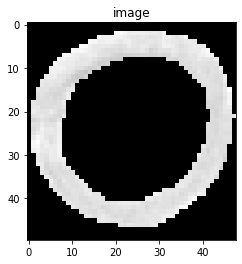

image shape: (50, 48, 7)
Cohort : 1 
Note: 0 = Healthy and 1 = MINF


In [ ]:
plt.title("image")
plt.imshow(img_loaded[0][:, :, 4], cmap="gray")
plt.show()

print(f"image shape: {img_loaded[0].shape}")
ch =train_labels[case_id]
print(f"Cohort : {ch} ")
print("Note: 0 = Healthy and 1 = MINF")
#img_loaded['image_meta_dict']

In [ ]:
class EmidecDataset(torch.utils.data.Dataset):
  def __init__(self, image_files, labels, clinical_info_df, transforms):
    self.image_files = image_files
    self.labels = labels
    self.transforms = train_transforms
    self.clinical_info = np.asarray(clinical_info_df)
  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    return self.transforms(self.image_files[index]), self.labels[index], self.clinical_info[index]

    #Note: to get the name of the files? -- when visualize with gradcam

In [ ]:
#Note: Check the batch size - CHANGE?! & num_workers =?
batch_size = 3
num_workers = 2
# Define data loaders (Training and Validation dataset)

train_ds = EmidecDataset(train_files, train_labels, clinical_info_train_scl, train_transforms) # SCALED CLINICAL FEATURES
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = EmidecDataset(val_files, val_labels, clinical_info_val_scl, val_transforms) # SCALED CLINICAL FEATURES
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

File name of the selected image :  /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P007.nii.gz 
Cohort name 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


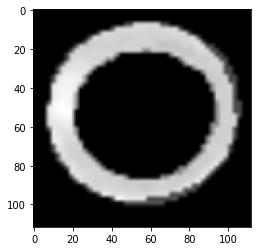

In [ ]:
#Check images after dataloader (with data transformations)
data_ex = train_ds[case_id]

#items = np.random.choice(len(train_ds), size=len(train_ds)) #*
#data = train_ds[item]  # this fetches training data with random augmentations #*
image_ex, label_ex = data_ex[0], data_ex[1]

print(f"File name of the selected image :  {train_ds.image_files[case_id]} ")
print(f"Cohort name {label_ex}")

# Detirmine the slice to be visualized
#the_slice = image_ex.shape[-1] // 2
#image_ex = image_ex.detach().cpu().numpy()
plt.imshow(image_ex[0,:,:,6], cmap="gray")

In [ ]:
seg_scar_ex = train_ds.image_files[case_id][:-7]
filename_seg_scar_ex = seg_scar_ex + "_gt_scar"+ ".nii.gz"
filename_seg_scar_ex

'/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P007_gt_scar.nii.gz'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


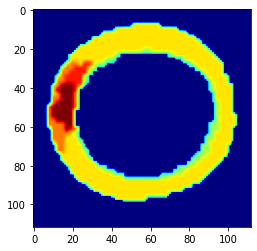

In [ ]:
seg_scar_ex_transformed = visualize_transforms(filename_seg_scar_ex)
plt.imshow(seg_scar_ex_transformed[0,:,:,6], cmap="jet")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#densenet = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=num_class).to(device) 

model_3d_resnet50 = monai.networks.nets.se_resnet50(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)
#model_3d_resnet50_32x4d = monai.networks.nets.se_resnext50_32x4d(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)
#model_3d_resnet101_32x4d = monai.networks.nets.se_resnext101_32x4d(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)


In [ ]:
device

device(type='cuda')

# **Model Modification (concatenate metadata)**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        resnet = monai.networks.nets.se_resnet50(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        #self.cnn.last_layer = nn.Linear(in_features=2048, out_features=2048, bias = True)
        # concatenate DL feats AND clinical featurs
        self.fc_clinic = nn.Linear(in_features=2048 + len(emidec_columns), out_features=2, bias = True)
        #self.last_layer = nn.Linear(in_features=2048  + len(emidec_columns) , out_features=2, bias = True)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
         
    def forward(self, image, clinic):
        x1 = self.resnet(image)
        x = x1.view(x1.size(0), -1)
        x2 = clinic

        
        x = torch.cat((x, x2), dim=1) # x2 = clinic does not have the same length --> put None
       
        x = x.type(torch.float32).to(device)
        x = self.fc_clinic(x)
   
        return x
        
#nn.Linear(in_features = 2048 + len(emidec_columns), out_features = 2, bias = True)

In [ ]:
model = MyModel()
#model = model_3d_resnet50

In [ ]:
model.children

<bound method Module.children of MyModel(
  (resnet): Sequential(
    (0): Sequential(
      (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (A): ReLU(inplace=True)
          )
        )
        (conv2): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# **TRAINING**

In [ ]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 100 # CHANGE Later




In [ ]:
# start the training  ################## 
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: #*
        step += 1
        inputs, labels, clinic  = batch_data[0].to(device), batch_data[1].to(device), batch_data[2].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, clinic)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size #*
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels, val_clinic = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                    val_data[2].to(device)
                )
                y_pred = torch.cat([y_pred, model(val_images, val_clinic)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            auc_metric = compute_roc_auc(
                y_pred, y, to_onehot_y=True, softmax=True)
            
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            metric_values.append(acc_metric)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),"best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best acc: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.3632
2/22, train_loss: 0.6043
3/22, train_loss: 0.3512
4/22, train_loss: 0.3394
5/22, train_loss: 0.3252
6/22, train_loss: 0.9246
7/22, train_loss: 0.2894
8/22, train_loss: 0.6399
9/22, train_loss: 1.2804
10/22, train_loss: 0.7122
11/22, train_loss: 0.5669
12/22, train_loss: 0.9815
13/22, train_loss: 0.5258
14/22, train_loss: 0.3432
15/22, train_loss: 0.6241
16/22, train_loss: 0.7971
17/22, train_loss: 0.5974
18/22, train_loss: 0.5689
19/22, train_loss: 0.9269
20/22, train_loss: 0.6308
21/22, train_loss: 0.5996
22/22, train_loss: 0.3193
23/22, train_loss: 1.0910
epoch 1 average loss: 0.6262


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


saved new best metric model
current epoch: 1 current AUC: 0.8492 current accuracy: 0.6364 best acc: 0.6364 at epoch: 1
----------
epoch 2/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.5585
2/22, train_loss: 0.3112
3/22, train_loss: 0.5156
4/22, train_loss: 0.3144
5/22, train_loss: 0.3171
6/22, train_loss: 0.8083
7/22, train_loss: 0.5336
8/22, train_loss: 0.5424
9/22, train_loss: 0.5406
10/22, train_loss: 0.4734
11/22, train_loss: 0.4155
12/22, train_loss: 0.3268
13/22, train_loss: 0.5492
14/22, train_loss: 0.5184
15/22, train_loss: 0.7732
16/22, train_loss: 0.4845
17/22, train_loss: 0.5702
18/22, train_loss: 0.3656
19/22, train_loss: 0.8549
20/22, train_loss: 0.3755
21/22, train_loss: 0.8455
22/22, train_loss: 0.5688
23/22, train_loss: 0.4036
epoch 2 average loss: 0.5203


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 2 current AUC: 0.7897 current accuracy: 0.6364 best acc: 0.6364 at epoch: 1
----------
epoch 3/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.7132
2/22, train_loss: 0.3510
3/22, train_loss: 0.4421
4/22, train_loss: 0.3500
5/22, train_loss: 0.3096
6/22, train_loss: 0.3546
7/22, train_loss: 0.3622
8/22, train_loss: 0.4326
9/22, train_loss: 0.4511
10/22, train_loss: 1.1176
11/22, train_loss: 0.3118
12/22, train_loss: 0.3632
13/22, train_loss: 0.7483
14/22, train_loss: 0.4028
15/22, train_loss: 0.3451
16/22, train_loss: 0.4495
17/22, train_loss: 0.3383
18/22, train_loss: 0.4630
19/22, train_loss: 0.4221
20/22, train_loss: 0.6356
21/22, train_loss: 0.4492
22/22, train_loss: 0.4782
23/22, train_loss: 1.1000
epoch 3 average loss: 0.4953


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 3 current AUC: 0.7857 current accuracy: 0.6364 best acc: 0.6364 at epoch: 1
----------
epoch 4/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.3900
2/22, train_loss: 0.4482
3/22, train_loss: 0.3367
4/22, train_loss: 0.3226
5/22, train_loss: 0.3196
6/22, train_loss: 0.3037
7/22, train_loss: 0.5583
8/22, train_loss: 0.4475
9/22, train_loss: 0.4178
10/22, train_loss: 0.4493
11/22, train_loss: 0.3754
12/22, train_loss: 0.5741
13/22, train_loss: 0.4002
14/22, train_loss: 0.3317
15/22, train_loss: 0.4663
16/22, train_loss: 0.3456
17/22, train_loss: 0.6611
18/22, train_loss: 0.3185
19/22, train_loss: 0.3367
20/22, train_loss: 0.5739
21/22, train_loss: 0.3693
22/22, train_loss: 0.2862
23/22, train_loss: 0.3667
epoch 4 average loss: 0.4087


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 4 current AUC: 0.8135 current accuracy: 0.6364 best acc: 0.6364 at epoch: 1
----------
epoch 5/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 1.0246
2/22, train_loss: 0.3374
3/22, train_loss: 0.2959
4/22, train_loss: 0.2477
5/22, train_loss: 0.2956
6/22, train_loss: 0.3618
7/22, train_loss: 0.3049
8/22, train_loss: 0.3568
9/22, train_loss: 0.3334
10/22, train_loss: 0.3303
11/22, train_loss: 0.3470
12/22, train_loss: 0.4861
13/22, train_loss: 0.2745
14/22, train_loss: 0.4095
15/22, train_loss: 0.2421
16/22, train_loss: 0.2978
17/22, train_loss: 0.3970
18/22, train_loss: 0.2815
19/22, train_loss: 0.3413
20/22, train_loss: 0.3129
21/22, train_loss: 0.6139
22/22, train_loss: 0.5367
23/22, train_loss: 1.0605
epoch 5 average loss: 0.4126


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 5 current AUC: 0.8135 current accuracy: 0.6364 best acc: 0.6364 at epoch: 1
----------
epoch 6/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.2881
2/22, train_loss: 0.1937
3/22, train_loss: 0.6329
4/22, train_loss: 0.2410
5/22, train_loss: 1.1093
6/22, train_loss: 0.3242
7/22, train_loss: 0.3597
8/22, train_loss: 0.3219
9/22, train_loss: 0.2696
10/22, train_loss: 0.1752
11/22, train_loss: 0.3063
12/22, train_loss: 0.2409
13/22, train_loss: 0.3342
14/22, train_loss: 0.5587
15/22, train_loss: 0.3674
16/22, train_loss: 0.3608
17/22, train_loss: 0.2237
18/22, train_loss: 0.3088
19/22, train_loss: 0.4716
20/22, train_loss: 0.3557
21/22, train_loss: 0.4768
22/22, train_loss: 0.3685
23/22, train_loss: 1.0953
epoch 6 average loss: 0.4080


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


saved new best metric model
current epoch: 6 current AUC: 0.8135 current accuracy: 0.6667 best acc: 0.6667 at epoch: 6
----------
epoch 7/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.2568
2/22, train_loss: 0.1719
3/22, train_loss: 0.2884
4/22, train_loss: 0.2363
5/22, train_loss: 0.1692
6/22, train_loss: 0.2192
7/22, train_loss: 0.3425
8/22, train_loss: 0.3431
9/22, train_loss: 0.3176
10/22, train_loss: 0.2361
11/22, train_loss: 0.2534
12/22, train_loss: 0.4293
13/22, train_loss: 0.9864
14/22, train_loss: 0.1981
15/22, train_loss: 0.2851
16/22, train_loss: 0.1862
17/22, train_loss: 0.2486
18/22, train_loss: 0.2831
19/22, train_loss: 0.3504
20/22, train_loss: 0.3976
21/22, train_loss: 0.2291
22/22, train_loss: 0.3931
23/22, train_loss: 0.2889
epoch 7 average loss: 0.3091


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


saved new best metric model
current epoch: 7 current AUC: 0.8135 current accuracy: 0.7879 best acc: 0.7879 at epoch: 7
----------
epoch 8/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.2867
2/22, train_loss: 0.1707
3/22, train_loss: 0.3203
4/22, train_loss: 0.1671
5/22, train_loss: 0.4115
6/22, train_loss: 1.0035
7/22, train_loss: 0.2676
8/22, train_loss: 0.3967
9/22, train_loss: 0.4119
10/22, train_loss: 0.3274
11/22, train_loss: 0.3130
12/22, train_loss: 0.3105
13/22, train_loss: 1.0439
14/22, train_loss: 0.3395
15/22, train_loss: 0.2527
16/22, train_loss: 0.3564
17/22, train_loss: 0.3383
18/22, train_loss: 0.2880
19/22, train_loss: 0.1184
20/22, train_loss: 0.2931
21/22, train_loss: 0.3597
22/22, train_loss: 0.2269
23/22, train_loss: 0.9760
epoch 8 average loss: 0.3904


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


saved new best metric model
current epoch: 8 current AUC: 0.8373 current accuracy: 0.8182 best acc: 0.8182 at epoch: 8
----------
epoch 9/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1699
2/22, train_loss: 0.2790
3/22, train_loss: 0.2422
4/22, train_loss: 0.1531
5/22, train_loss: 0.3210
6/22, train_loss: 0.1519
7/22, train_loss: 0.1309
8/22, train_loss: 0.3551
9/22, train_loss: 0.3369
10/22, train_loss: 0.1584
11/22, train_loss: 0.4589
12/22, train_loss: 0.2796
13/22, train_loss: 0.2501
14/22, train_loss: 0.2904
15/22, train_loss: 0.3089
16/22, train_loss: 0.9615
17/22, train_loss: 0.1330
18/22, train_loss: 0.1646
19/22, train_loss: 0.2970
20/22, train_loss: 0.1047
21/22, train_loss: 0.2909
22/22, train_loss: 0.2878
23/22, train_loss: 1.1317
epoch 9 average loss: 0.3156


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 9 current AUC: 0.8016 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 10/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1424
2/22, train_loss: 0.2612
3/22, train_loss: 0.1212
4/22, train_loss: 0.2669
5/22, train_loss: 0.1933
6/22, train_loss: 0.1292
7/22, train_loss: 0.2886
8/22, train_loss: 0.5155
9/22, train_loss: 1.0226
10/22, train_loss: 0.3129
11/22, train_loss: 0.2854
12/22, train_loss: 0.2715
13/22, train_loss: 0.2012
14/22, train_loss: 0.1700
15/22, train_loss: 0.3183
16/22, train_loss: 0.1212
17/22, train_loss: 0.1895
18/22, train_loss: 0.2856
19/22, train_loss: 0.1154
20/22, train_loss: 0.2094
21/22, train_loss: 0.0791
22/22, train_loss: 0.2050
23/22, train_loss: 0.2728
epoch 10 average loss: 0.2599


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 10 current AUC: 0.7857 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 11/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1057
2/22, train_loss: 0.1077
3/22, train_loss: 0.2394
4/22, train_loss: 0.1135
5/22, train_loss: 0.3378
6/22, train_loss: 0.1000
7/22, train_loss: 0.3406
8/22, train_loss: 0.2582
9/22, train_loss: 0.0744
10/22, train_loss: 0.2787
11/22, train_loss: 0.2719
12/22, train_loss: 0.1025
13/22, train_loss: 0.1942
14/22, train_loss: 0.2965
15/22, train_loss: 0.1014
16/22, train_loss: 0.2721
17/22, train_loss: 0.1056
18/22, train_loss: 0.2457
19/22, train_loss: 0.2288
20/22, train_loss: 0.2673
21/22, train_loss: 0.2533
22/22, train_loss: 0.2686
23/22, train_loss: 0.2723
epoch 11 average loss: 0.2103


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 11 current AUC: 0.8095 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 12/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.2608
2/22, train_loss: 0.0639
3/22, train_loss: 0.2099
4/22, train_loss: 0.2405
5/22, train_loss: 0.2504
6/22, train_loss: 0.2552
7/22, train_loss: 0.2513
8/22, train_loss: 0.0712
9/22, train_loss: 0.2580
10/22, train_loss: 0.2201
11/22, train_loss: 0.0680
12/22, train_loss: 0.2150
13/22, train_loss: 0.0869
14/22, train_loss: 0.0653
15/22, train_loss: 0.2035
16/22, train_loss: 0.2369
17/22, train_loss: 0.0875
18/22, train_loss: 0.1273
19/22, train_loss: 1.0926
20/22, train_loss: 0.3059
21/22, train_loss: 0.0749
22/22, train_loss: 0.2611
23/22, train_loss: 0.2478
epoch 12 average loss: 0.2241


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 12 current AUC: 0.7897 current accuracy: 0.8182 best acc: 0.8182 at epoch: 8
----------
epoch 13/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0592
2/22, train_loss: 0.2734
3/22, train_loss: 1.0729
4/22, train_loss: 0.0710
5/22, train_loss: 0.1382
6/22, train_loss: 0.2497
7/22, train_loss: 0.2086
8/22, train_loss: 0.1848
9/22, train_loss: 0.2122
10/22, train_loss: 0.1490
11/22, train_loss: 0.0485
12/22, train_loss: 0.3370
13/22, train_loss: 0.2451
14/22, train_loss: 0.1454
15/22, train_loss: 0.0459
16/22, train_loss: 0.2516
17/22, train_loss: 0.2176
18/22, train_loss: 0.2321
19/22, train_loss: 0.0527
20/22, train_loss: 0.0484
21/22, train_loss: 0.2484
22/22, train_loss: 0.2358
23/22, train_loss: 0.2552
epoch 13 average loss: 0.2166


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 13 current AUC: 0.8254 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 14/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0514
2/22, train_loss: 0.0625
3/22, train_loss: 0.0446
4/22, train_loss: 0.2272
5/22, train_loss: 0.2201
6/22, train_loss: 0.2607
7/22, train_loss: 0.0642
8/22, train_loss: 0.1046
9/22, train_loss: 0.0407
10/22, train_loss: 0.2001
11/22, train_loss: 1.2114
12/22, train_loss: 0.0884
13/22, train_loss: 0.0492
14/22, train_loss: 0.0569
15/22, train_loss: 0.0774
16/22, train_loss: 0.0594
17/22, train_loss: 0.0886
18/22, train_loss: 0.1968
19/22, train_loss: 0.0555
20/22, train_loss: 0.0440
21/22, train_loss: 0.0439
22/22, train_loss: 0.0502
23/22, train_loss: 0.1751
epoch 14 average loss: 0.1510


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 14 current AUC: 0.8016 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 15/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.2810
2/22, train_loss: 0.1930
3/22, train_loss: 0.1958
4/22, train_loss: 0.0420
5/22, train_loss: 0.0342
6/22, train_loss: 0.0389
7/22, train_loss: 0.0591
8/22, train_loss: 0.1949
9/22, train_loss: 0.3502
10/22, train_loss: 0.2089
11/22, train_loss: 0.1850
12/22, train_loss: 0.0384
13/22, train_loss: 0.1350
14/22, train_loss: 0.0352
15/22, train_loss: 0.1289
16/22, train_loss: 0.2218
17/22, train_loss: 0.0388
18/22, train_loss: 0.0412
19/22, train_loss: 0.1921
20/22, train_loss: 0.1614
21/22, train_loss: 0.1863
22/22, train_loss: 0.0777
23/22, train_loss: 0.1904
epoch 15 average loss: 0.1404


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 15 current AUC: 0.7937 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 16/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0330
2/22, train_loss: 0.0351
3/22, train_loss: 0.1955
4/22, train_loss: 0.0304
5/22, train_loss: 1.0996
6/22, train_loss: 0.0298
7/22, train_loss: 0.1487
8/22, train_loss: 0.1463
9/22, train_loss: 0.1725
10/22, train_loss: 0.1357
11/22, train_loss: 0.2021
12/22, train_loss: 0.0375
13/22, train_loss: 0.1754
14/22, train_loss: 0.0328
15/22, train_loss: 0.0264
16/22, train_loss: 0.2011
17/22, train_loss: 0.0229
18/22, train_loss: 0.2088
19/22, train_loss: 0.2132
20/22, train_loss: 0.0411
21/22, train_loss: 0.0407
22/22, train_loss: 0.2061
23/22, train_loss: 0.2343
epoch 16 average loss: 0.1595


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 16 current AUC: 0.8254 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 17/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1892
2/22, train_loss: 0.1911
3/22, train_loss: 0.2020
4/22, train_loss: 0.0312
5/22, train_loss: 0.1087
6/22, train_loss: 0.0273
7/22, train_loss: 0.2025
8/22, train_loss: 0.0223
9/22, train_loss: 0.0405
10/22, train_loss: 0.0221
11/22, train_loss: 0.1598
12/22, train_loss: 0.2156
13/22, train_loss: 0.1900
14/22, train_loss: 0.0366
15/22, train_loss: 0.3500
16/22, train_loss: 0.1566
17/22, train_loss: 0.1511
18/22, train_loss: 0.0982
19/22, train_loss: 0.1031
20/22, train_loss: 0.1327
21/22, train_loss: 0.0256
22/22, train_loss: 0.1492
23/22, train_loss: 0.1640
epoch 17 average loss: 0.1291


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 17 current AUC: 0.8373 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 18/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0166
2/22, train_loss: 0.0150
3/22, train_loss: 0.0269
4/22, train_loss: 0.0242
5/22, train_loss: 0.0196
6/22, train_loss: 0.0993
7/22, train_loss: 0.0193
8/22, train_loss: 0.1374
9/22, train_loss: 1.2302
10/22, train_loss: 0.0242
11/22, train_loss: 0.0191
12/22, train_loss: 0.1724
13/22, train_loss: 0.0172
14/22, train_loss: 0.1918
15/22, train_loss: 0.0145
16/22, train_loss: 0.0176
17/22, train_loss: 0.0981
18/22, train_loss: 0.2000
19/22, train_loss: 0.1709
20/22, train_loss: 0.0427
21/22, train_loss: 0.1722
22/22, train_loss: 0.1759
23/22, train_loss: 0.1822
epoch 18 average loss: 0.1342


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 18 current AUC: 0.8254 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 19/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0400
2/22, train_loss: 0.0967
3/22, train_loss: 0.0134
4/22, train_loss: 0.1758
5/22, train_loss: 0.0131
6/22, train_loss: 0.1642
7/22, train_loss: 0.1353
8/22, train_loss: 1.1783
9/22, train_loss: 0.0805
10/22, train_loss: 0.1776
11/22, train_loss: 0.0172
12/22, train_loss: 0.2133
13/22, train_loss: 0.0211
14/22, train_loss: 0.1580
15/22, train_loss: 0.0205
16/22, train_loss: 0.1529
17/22, train_loss: 0.1455
18/22, train_loss: 0.0131
19/22, train_loss: 0.0911
20/22, train_loss: 0.0097
21/22, train_loss: 0.0217
22/22, train_loss: 0.1546
23/22, train_loss: 1.4876
epoch 19 average loss: 0.1992


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 19 current AUC: 0.8373 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 20/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0102
2/22, train_loss: 0.1509
3/22, train_loss: 0.2423
4/22, train_loss: 0.0089
5/22, train_loss: 0.1536
6/22, train_loss: 0.0192
7/22, train_loss: 0.0573
8/22, train_loss: 0.0102
9/22, train_loss: 0.1393
10/22, train_loss: 0.0873
11/22, train_loss: 0.0214
12/22, train_loss: 0.0704
13/22, train_loss: 0.0359
14/22, train_loss: 0.0179
15/22, train_loss: 0.1726
16/22, train_loss: 0.0135
17/22, train_loss: 0.0137
18/22, train_loss: 0.2203
19/22, train_loss: 0.0126
20/22, train_loss: 0.1792
21/22, train_loss: 0.0125
22/22, train_loss: 0.0656
23/22, train_loss: 0.1575
epoch 20 average loss: 0.0814


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 20 current AUC: 0.8175 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 21/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0204
2/22, train_loss: 0.1132
3/22, train_loss: 0.1322
4/22, train_loss: 0.0119
5/22, train_loss: 0.0777
6/22, train_loss: 0.0117
7/22, train_loss: 0.0749
8/22, train_loss: 0.1735
9/22, train_loss: 0.0103
10/22, train_loss: 0.0098
11/22, train_loss: 0.1547
12/22, train_loss: 0.1824
13/22, train_loss: 0.1550
14/22, train_loss: 0.0118
15/22, train_loss: 0.0101
16/22, train_loss: 0.1010
17/22, train_loss: 0.0123
18/22, train_loss: 0.0076
19/22, train_loss: 0.0697
20/22, train_loss: 0.1391
21/22, train_loss: 0.1325
22/22, train_loss: 0.1383
23/22, train_loss: 0.1220
epoch 21 average loss: 0.0814


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 21 current AUC: 0.8294 current accuracy: 0.6061 best acc: 0.8182 at epoch: 8
----------
epoch 22/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0629
2/22, train_loss: 0.2007
3/22, train_loss: 0.2001
4/22, train_loss: 0.0097
5/22, train_loss: 0.0184
6/22, train_loss: 0.1504
7/22, train_loss: 0.0145
8/22, train_loss: 0.1065
9/22, train_loss: 0.1571
10/22, train_loss: 0.0079
11/22, train_loss: 0.0134
12/22, train_loss: 0.2415
13/22, train_loss: 1.3646
14/22, train_loss: 0.1545
15/22, train_loss: 0.1806
16/22, train_loss: 0.1653
17/22, train_loss: 1.3569
18/22, train_loss: 0.0119
19/22, train_loss: 0.0083
20/22, train_loss: 0.0652
21/22, train_loss: 0.0697
22/22, train_loss: 0.1571
23/22, train_loss: 0.0987
epoch 22 average loss: 0.2094


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 22 current AUC: 0.8175 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 23/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0086
2/22, train_loss: 0.1578
3/22, train_loss: 0.0078
4/22, train_loss: 0.0116
5/22, train_loss: 0.1220
6/22, train_loss: 0.0088
7/22, train_loss: 0.1032
8/22, train_loss: 0.0168
9/22, train_loss: 0.1015
10/22, train_loss: 1.2242
11/22, train_loss: 0.1458
12/22, train_loss: 0.1397
13/22, train_loss: 0.1513
14/22, train_loss: 0.0103
15/22, train_loss: 0.1415
16/22, train_loss: 0.0813
17/22, train_loss: 0.0589
18/22, train_loss: 0.1383
19/22, train_loss: 0.0083
20/22, train_loss: 0.0098
21/22, train_loss: 0.0112
22/22, train_loss: 0.1408
23/22, train_loss: 1.1804
epoch 23 average loss: 0.1730


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 23 current AUC: 0.8333 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 24/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0638
2/22, train_loss: 0.0108
3/22, train_loss: 0.0496
4/22, train_loss: 0.1436
5/22, train_loss: 0.0057
6/22, train_loss: 0.0111
7/22, train_loss: 0.0164
8/22, train_loss: 0.0096
9/22, train_loss: 0.0486
10/22, train_loss: 0.0247
11/22, train_loss: 0.0101
12/22, train_loss: 0.0071
13/22, train_loss: 0.1376
14/22, train_loss: 0.1855
15/22, train_loss: 0.1668
16/22, train_loss: 0.0083
17/22, train_loss: 0.1528
18/22, train_loss: 0.1600
19/22, train_loss: 0.0075
20/22, train_loss: 0.1466
21/22, train_loss: 0.1123
22/22, train_loss: 0.1523
23/22, train_loss: 0.9792
epoch 24 average loss: 0.1135


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 24 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 25/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1767
2/22, train_loss: 0.0447
3/22, train_loss: 0.0089
4/22, train_loss: 0.0563
5/22, train_loss: 0.1382
6/22, train_loss: 0.1429
7/22, train_loss: 0.0086
8/22, train_loss: 0.0112
9/22, train_loss: 0.0466
10/22, train_loss: 0.0104
11/22, train_loss: 0.0533
12/22, train_loss: 0.0135
13/22, train_loss: 0.1427
14/22, train_loss: 0.1622
15/22, train_loss: 0.0066
16/22, train_loss: 0.0937
17/22, train_loss: 0.1552
18/22, train_loss: 0.0106
19/22, train_loss: 0.0080
20/22, train_loss: 0.0223
21/22, train_loss: 0.0076
22/22, train_loss: 0.1601
23/22, train_loss: 1.5340
epoch 25 average loss: 0.1311


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 25 current AUC: 0.8452 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 26/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0057
2/22, train_loss: 0.0518
3/22, train_loss: 0.0098
4/22, train_loss: 0.0391
5/22, train_loss: 0.1604
6/22, train_loss: 0.1469
7/22, train_loss: 0.1479
8/22, train_loss: 0.0089
9/22, train_loss: 0.0131
10/22, train_loss: 0.0067
11/22, train_loss: 0.0602
12/22, train_loss: 0.0505
13/22, train_loss: 0.1530
14/22, train_loss: 0.0058
15/22, train_loss: 0.0056
16/22, train_loss: 0.1602
17/22, train_loss: 0.0094
18/22, train_loss: 0.1684
19/22, train_loss: 0.1705
20/22, train_loss: 0.0066
21/22, train_loss: 0.0474
22/22, train_loss: 0.0482
23/22, train_loss: 0.1217
epoch 26 average loss: 0.0695


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 26 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 27/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0517
2/22, train_loss: 0.0091
3/22, train_loss: 0.0082
4/22, train_loss: 0.0048
5/22, train_loss: 0.1345
6/22, train_loss: 0.0056
7/22, train_loss: 0.1347
8/22, train_loss: 0.1540
9/22, train_loss: 0.0577
10/22, train_loss: 0.0384
11/22, train_loss: 0.1228
12/22, train_loss: 0.1387
13/22, train_loss: 0.2156
14/22, train_loss: 0.1116
15/22, train_loss: 0.1229
16/22, train_loss: 0.1310
17/22, train_loss: 1.3281
18/22, train_loss: 0.1347
19/22, train_loss: 0.0060
20/22, train_loss: 0.0427
21/22, train_loss: 0.1287
22/22, train_loss: 0.0640
23/22, train_loss: 1.7724
epoch 27 average loss: 0.2138


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 27 current AUC: 0.8135 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 28/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0763
2/22, train_loss: 0.0085
3/22, train_loss: 0.0423
4/22, train_loss: 0.0051
5/22, train_loss: 0.0383
6/22, train_loss: 0.1198
7/22, train_loss: 0.1849
8/22, train_loss: 0.0107
9/22, train_loss: 0.0041
10/22, train_loss: 0.0064
11/22, train_loss: 0.0073
12/22, train_loss: 0.1328
13/22, train_loss: 0.1282
14/22, train_loss: 0.0073
15/22, train_loss: 0.0041
16/22, train_loss: 0.0064
17/22, train_loss: 0.1287
18/22, train_loss: 0.1441
19/22, train_loss: 0.0046
20/22, train_loss: 0.0519
21/22, train_loss: 0.0055
22/22, train_loss: 0.0517
23/22, train_loss: 0.1602
epoch 28 average loss: 0.0578


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 28 current AUC: 0.8175 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 29/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1324
2/22, train_loss: 0.0061
3/22, train_loss: 0.1136
4/22, train_loss: 0.0062
5/22, train_loss: 0.0159
6/22, train_loss: 0.0058
7/22, train_loss: 0.0086
8/22, train_loss: 0.0097
9/22, train_loss: 0.0622
10/22, train_loss: 0.0771
11/22, train_loss: 0.1241
12/22, train_loss: 0.0603
13/22, train_loss: 0.1035
14/22, train_loss: 0.0051
15/22, train_loss: 0.0205
16/22, train_loss: 0.1331
17/22, train_loss: 0.0581
18/22, train_loss: 0.1377
19/22, train_loss: 0.0041
20/22, train_loss: 1.3543
21/22, train_loss: 0.1449
22/22, train_loss: 0.1408
23/22, train_loss: 1.3920
epoch 29 average loss: 0.1790


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 29 current AUC: 0.8294 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 30/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0056
2/22, train_loss: 0.1239
3/22, train_loss: 0.0482
4/22, train_loss: 0.0071
5/22, train_loss: 0.0329
6/22, train_loss: 0.1135
7/22, train_loss: 0.0042
8/22, train_loss: 0.0441
9/22, train_loss: 0.1587
10/22, train_loss: 0.1847
11/22, train_loss: 0.1610
12/22, train_loss: 0.0180
13/22, train_loss: 0.0067
14/22, train_loss: 0.0057
15/22, train_loss: 0.0208
16/22, train_loss: 0.0329
17/22, train_loss: 0.0046
18/22, train_loss: 0.0347
19/22, train_loss: 0.1368
20/22, train_loss: 0.1884
21/22, train_loss: 0.0151
22/22, train_loss: 0.0389
23/22, train_loss: 0.1131
epoch 30 average loss: 0.0652


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 30 current AUC: 0.8135 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 31/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0049
2/22, train_loss: 0.0611
3/22, train_loss: 0.0081
4/22, train_loss: 1.4541
5/22, train_loss: 0.0047
6/22, train_loss: 0.0055
7/22, train_loss: 0.1134
8/22, train_loss: 0.1806
9/22, train_loss: 0.0042
10/22, train_loss: 0.1177
11/22, train_loss: 0.1395
12/22, train_loss: 0.2260
13/22, train_loss: 0.0097
14/22, train_loss: 0.2289
15/22, train_loss: 0.0078
16/22, train_loss: 0.1228
17/22, train_loss: 0.0265
18/22, train_loss: 0.0395
19/22, train_loss: 0.1910
20/22, train_loss: 0.0068
21/22, train_loss: 0.0063
22/22, train_loss: 0.0398
23/22, train_loss: 1.5533
epoch 31 average loss: 0.1979


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 31 current AUC: 0.8135 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 32/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0048
2/22, train_loss: 0.1134
3/22, train_loss: 0.1231
4/22, train_loss: 0.0427
5/22, train_loss: 0.0047
6/22, train_loss: 0.0062
7/22, train_loss: 0.0055
8/22, train_loss: 0.0039
9/22, train_loss: 0.3001
10/22, train_loss: 0.0522
11/22, train_loss: 0.0112
12/22, train_loss: 0.0052
13/22, train_loss: 0.1717
14/22, train_loss: 0.0100
15/22, train_loss: 0.0060
16/22, train_loss: 0.0134
17/22, train_loss: 0.1289
18/22, train_loss: 0.0142
19/22, train_loss: 0.0077
20/22, train_loss: 0.1861
21/22, train_loss: 0.0399
22/22, train_loss: 0.1344
23/22, train_loss: 1.4521
epoch 32 average loss: 0.1234


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 32 current AUC: 0.8294 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 33/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1971
2/22, train_loss: 0.1281
3/22, train_loss: 1.4131
4/22, train_loss: 0.0067
5/22, train_loss: 1.5868
6/22, train_loss: 0.0062
7/22, train_loss: 0.0054
8/22, train_loss: 0.0054
9/22, train_loss: 0.0081
10/22, train_loss: 0.0083
11/22, train_loss: 0.0062
12/22, train_loss: 0.0122
13/22, train_loss: 0.0105
14/22, train_loss: 0.1775
15/22, train_loss: 0.0096
16/22, train_loss: 0.1813
17/22, train_loss: 0.0056
18/22, train_loss: 0.1639
19/22, train_loss: 0.0069
20/22, train_loss: 0.0070
21/22, train_loss: 0.1688
22/22, train_loss: 0.1904
23/22, train_loss: 0.1576
epoch 33 average loss: 0.1940


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 33 current AUC: 0.8254 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 34/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1504
2/22, train_loss: 0.0434
3/22, train_loss: 0.2223
4/22, train_loss: 0.0073
5/22, train_loss: 0.1510
6/22, train_loss: 0.0432
7/22, train_loss: 0.2167
8/22, train_loss: 0.0477
9/22, train_loss: 0.1747
10/22, train_loss: 0.1860
11/22, train_loss: 0.0070
12/22, train_loss: 0.0068
13/22, train_loss: 0.0990
14/22, train_loss: 0.1443
15/22, train_loss: 0.0065
16/22, train_loss: 0.1339
17/22, train_loss: 0.0103
18/22, train_loss: 0.0063
19/22, train_loss: 0.0573
20/22, train_loss: 0.0034
21/22, train_loss: 0.1164
22/22, train_loss: 0.0659
23/22, train_loss: 0.1402
epoch 34 average loss: 0.0887


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 34 current AUC: 0.8135 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 35/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0101
2/22, train_loss: 0.0065
3/22, train_loss: 0.0084
4/22, train_loss: 0.1352
5/22, train_loss: 0.1242
6/22, train_loss: 0.0038
7/22, train_loss: 0.0609
8/22, train_loss: 0.0067
9/22, train_loss: 0.0944
10/22, train_loss: 0.1678
11/22, train_loss: 0.1433
12/22, train_loss: 0.1678
13/22, train_loss: 0.1159
14/22, train_loss: 0.1370
15/22, train_loss: 0.0064
16/22, train_loss: 0.1041
17/22, train_loss: 0.0044
18/22, train_loss: 0.0499
19/22, train_loss: 0.0521
20/22, train_loss: 0.1275
21/22, train_loss: 0.0369
22/22, train_loss: 0.0185
23/22, train_loss: 1.3344
epoch 35 average loss: 0.1268


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 35 current AUC: 0.8214 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 36/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0066
2/22, train_loss: 0.0052
3/22, train_loss: 0.0539
4/22, train_loss: 0.0379
5/22, train_loss: 0.0112
6/22, train_loss: 0.0494
7/22, train_loss: 0.0063
8/22, train_loss: 0.1746
9/22, train_loss: 0.0075
10/22, train_loss: 0.0037
11/22, train_loss: 0.0042
12/22, train_loss: 0.1456
13/22, train_loss: 0.1506
14/22, train_loss: 0.0051
15/22, train_loss: 0.1432
16/22, train_loss: 0.1472
17/22, train_loss: 0.1887
18/22, train_loss: 0.0087
19/22, train_loss: 0.0395
20/22, train_loss: 0.1397
21/22, train_loss: 0.1401
22/22, train_loss: 0.0079
23/22, train_loss: 1.3566
epoch 36 average loss: 0.1232


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 36 current AUC: 0.8452 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 37/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0368
2/22, train_loss: 0.0032
3/22, train_loss: 0.1151
4/22, train_loss: 0.0356
5/22, train_loss: 0.0212
6/22, train_loss: 0.0083
7/22, train_loss: 0.1205
8/22, train_loss: 0.0061
9/22, train_loss: 0.0060
10/22, train_loss: 0.0253
11/22, train_loss: 0.0102
12/22, train_loss: 0.0148
13/22, train_loss: 0.0544
14/22, train_loss: 0.1020
15/22, train_loss: 0.0054
16/22, train_loss: 0.1424
17/22, train_loss: 0.0143
18/22, train_loss: 0.0043
19/22, train_loss: 0.0408
20/22, train_loss: 0.1555
21/22, train_loss: 0.1752
22/22, train_loss: 0.0041
23/22, train_loss: 0.1252
epoch 37 average loss: 0.0533


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 37 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 38/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0035
2/22, train_loss: 0.0035
3/22, train_loss: 0.1463
4/22, train_loss: 0.0419
5/22, train_loss: 0.0058
6/22, train_loss: 0.0113
7/22, train_loss: 0.0049
8/22, train_loss: 0.0028
9/22, train_loss: 0.2175
10/22, train_loss: 0.0108
11/22, train_loss: 0.0053
12/22, train_loss: 0.0468
13/22, train_loss: 0.1657
14/22, train_loss: 0.1206
15/22, train_loss: 0.0494
16/22, train_loss: 0.0038
17/22, train_loss: 0.0029
18/22, train_loss: 0.1601
19/22, train_loss: 0.0051
20/22, train_loss: 0.0501
21/22, train_loss: 0.0285
22/22, train_loss: 0.1068
23/22, train_loss: 0.0925
epoch 38 average loss: 0.0559


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 38 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 39/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0025
2/22, train_loss: 0.0971
3/22, train_loss: 0.1307
4/22, train_loss: 0.0997
5/22, train_loss: 0.0403
6/22, train_loss: 0.1151
7/22, train_loss: 1.6145
8/22, train_loss: 0.0068
9/22, train_loss: 0.0373
10/22, train_loss: 0.1319
11/22, train_loss: 0.0041
12/22, train_loss: 0.0075
13/22, train_loss: 0.0511
14/22, train_loss: 0.0041
15/22, train_loss: 0.1837
16/22, train_loss: 0.0945
17/22, train_loss: 0.0272
18/22, train_loss: 0.0050
19/22, train_loss: 0.0127
20/22, train_loss: 0.0051
21/22, train_loss: 0.1533
22/22, train_loss: 0.0355
23/22, train_loss: 0.0912
epoch 39 average loss: 0.1283


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 39 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 40/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0062
2/22, train_loss: 0.0050
3/22, train_loss: 0.0286
4/22, train_loss: 0.0093
5/22, train_loss: 0.0029
6/22, train_loss: 0.1058
7/22, train_loss: 0.1723
8/22, train_loss: 0.0039
9/22, train_loss: 0.0411
10/22, train_loss: 0.0804
11/22, train_loss: 0.0257
12/22, train_loss: 0.0029
13/22, train_loss: 0.1560
14/22, train_loss: 0.0040
15/22, train_loss: 0.0038
16/22, train_loss: 0.1514
17/22, train_loss: 0.0044
18/22, train_loss: 0.1423
19/22, train_loss: 0.2199
20/22, train_loss: 0.0539
21/22, train_loss: 0.1052
22/22, train_loss: 0.0319
23/22, train_loss: 0.0870
epoch 40 average loss: 0.0628


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 40 current AUC: 0.8452 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 41/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0031
2/22, train_loss: 0.0999
3/22, train_loss: 0.0767
4/22, train_loss: 0.1056
5/22, train_loss: 0.0927
6/22, train_loss: 0.0033
7/22, train_loss: 0.0040
8/22, train_loss: 0.0123
9/22, train_loss: 0.0568
10/22, train_loss: 0.0031
11/22, train_loss: 0.0041
12/22, train_loss: 0.0713
13/22, train_loss: 0.0839
14/22, train_loss: 0.0090
15/22, train_loss: 0.1580
16/22, train_loss: 0.0023
17/22, train_loss: 1.7474
18/22, train_loss: 0.0034
19/22, train_loss: 0.0029
20/22, train_loss: 0.0030
21/22, train_loss: 0.0482
22/22, train_loss: 0.0568
23/22, train_loss: 1.7996
epoch 41 average loss: 0.1934


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 41 current AUC: 0.8214 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 42/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0043
2/22, train_loss: 0.0033
3/22, train_loss: 0.0069
4/22, train_loss: 0.0037
5/22, train_loss: 0.0028
6/22, train_loss: 1.4744
7/22, train_loss: 0.1126
8/22, train_loss: 0.0023
9/22, train_loss: 0.0260
10/22, train_loss: 1.9626
11/22, train_loss: 0.2465
12/22, train_loss: 0.0028
13/22, train_loss: 0.1926
14/22, train_loss: 0.0069
15/22, train_loss: 0.0973
16/22, train_loss: 0.1401
17/22, train_loss: 0.0420
18/22, train_loss: 0.0053
19/22, train_loss: 0.0802
20/22, train_loss: 0.0056
21/22, train_loss: 0.0906
22/22, train_loss: 0.1060
23/22, train_loss: 1.1659
epoch 42 average loss: 0.2514


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 42 current AUC: 0.8492 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 43/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0326
2/22, train_loss: 0.0052
3/22, train_loss: 0.0196
4/22, train_loss: 0.1035
5/22, train_loss: 0.0358
6/22, train_loss: 0.0043
7/22, train_loss: 0.1179
8/22, train_loss: 0.0552
9/22, train_loss: 0.0937
10/22, train_loss: 0.1361
11/22, train_loss: 0.1950
12/22, train_loss: 0.0045
13/22, train_loss: 0.0079
14/22, train_loss: 0.1255
15/22, train_loss: 0.0066
16/22, train_loss: 0.1203
17/22, train_loss: 0.1251
18/22, train_loss: 0.0050
19/22, train_loss: 0.1037
20/22, train_loss: 0.1514
21/22, train_loss: 1.1552
22/22, train_loss: 0.0975
23/22, train_loss: 0.1211
epoch 43 average loss: 0.1227


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 43 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 44/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0237
2/22, train_loss: 0.1015
3/22, train_loss: 0.0065
4/22, train_loss: 0.0394
5/22, train_loss: 0.0048
6/22, train_loss: 0.1053
7/22, train_loss: 0.1562
8/22, train_loss: 0.0026
9/22, train_loss: 0.0059
10/22, train_loss: 0.0047
11/22, train_loss: 0.0284
12/22, train_loss: 0.1726
13/22, train_loss: 0.0040
14/22, train_loss: 0.0032
15/22, train_loss: 0.1235
16/22, train_loss: 0.0047
17/22, train_loss: 0.0060
18/22, train_loss: 0.0062
19/22, train_loss: 0.0042
20/22, train_loss: 0.0049
21/22, train_loss: 0.0046
22/22, train_loss: 0.0403
23/22, train_loss: 0.0809
epoch 44 average loss: 0.0406


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 44 current AUC: 0.8214 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 45/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0975
2/22, train_loss: 0.1048
3/22, train_loss: 0.0031
4/22, train_loss: 0.0284
5/22, train_loss: 0.0039
6/22, train_loss: 0.0975
7/22, train_loss: 0.0064
8/22, train_loss: 0.1275
9/22, train_loss: 0.0161
10/22, train_loss: 0.0054
11/22, train_loss: 0.0922
12/22, train_loss: 0.1215
13/22, train_loss: 0.0033
14/22, train_loss: 0.0324
15/22, train_loss: 0.0098
16/22, train_loss: 0.0376
17/22, train_loss: 0.0057
18/22, train_loss: 0.0051
19/22, train_loss: 0.0407
20/22, train_loss: 0.0042
21/22, train_loss: 0.0036
22/22, train_loss: 0.0027
23/22, train_loss: 1.7609
epoch 45 average loss: 0.1135


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 45 current AUC: 0.8294 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 46/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1175
2/22, train_loss: 0.0280
3/22, train_loss: 0.0904
4/22, train_loss: 0.1238
5/22, train_loss: 0.0056
6/22, train_loss: 0.0041
7/22, train_loss: 0.1157
8/22, train_loss: 0.0415
9/22, train_loss: 0.0912
10/22, train_loss: 0.0043
11/22, train_loss: 0.1105
12/22, train_loss: 0.1183
13/22, train_loss: 0.0315
14/22, train_loss: 1.5909
15/22, train_loss: 0.0025
16/22, train_loss: 0.0036
17/22, train_loss: 0.0033
18/22, train_loss: 0.0094
19/22, train_loss: 0.0048
20/22, train_loss: 0.0032
21/22, train_loss: 0.0029
22/22, train_loss: 0.0075
23/22, train_loss: 1.0925
epoch 46 average loss: 0.1567


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 46 current AUC: 0.8452 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 47/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0236
2/22, train_loss: 0.0031
3/22, train_loss: 0.0076
4/22, train_loss: 0.0031
5/22, train_loss: 0.1380
6/22, train_loss: 0.0037
7/22, train_loss: 0.0043
8/22, train_loss: 0.0054
9/22, train_loss: 0.1855
10/22, train_loss: 0.0031
11/22, train_loss: 0.0035
12/22, train_loss: 0.0964
13/22, train_loss: 0.0031
14/22, train_loss: 0.0089
15/22, train_loss: 0.0026
16/22, train_loss: 0.1722
17/22, train_loss: 0.0069
18/22, train_loss: 0.0042
19/22, train_loss: 0.0069
20/22, train_loss: 0.0051
21/22, train_loss: 0.0035
22/22, train_loss: 0.0042
23/22, train_loss: 0.1432
epoch 47 average loss: 0.0364


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 47 current AUC: 0.8413 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 48/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0991
2/22, train_loss: 0.2096
3/22, train_loss: 0.1433
4/22, train_loss: 0.0038
5/22, train_loss: 0.0279
6/22, train_loss: 0.0039
7/22, train_loss: 0.0036
8/22, train_loss: 1.4504
9/22, train_loss: 0.0212
10/22, train_loss: 0.1087
11/22, train_loss: 0.0035
12/22, train_loss: 0.0042
13/22, train_loss: 1.3981
14/22, train_loss: 0.1388
15/22, train_loss: 0.0281
16/22, train_loss: 0.1163
17/22, train_loss: 0.1218
18/22, train_loss: 0.1340
19/22, train_loss: 0.1159
20/22, train_loss: 0.0035
21/22, train_loss: 0.1336
22/22, train_loss: 1.3955
23/22, train_loss: 0.1057
epoch 48 average loss: 0.2509


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 48 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 49/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1386
2/22, train_loss: 0.1093
3/22, train_loss: 0.0045
4/22, train_loss: 0.1354
5/22, train_loss: 1.1011
6/22, train_loss: 0.1424
7/22, train_loss: 0.0139
8/22, train_loss: 0.0073
9/22, train_loss: 0.0024
10/22, train_loss: 0.0033
11/22, train_loss: 0.0065
12/22, train_loss: 0.0044
13/22, train_loss: 0.0065
14/22, train_loss: 0.0055
15/22, train_loss: 0.0048
16/22, train_loss: 0.0038
17/22, train_loss: 0.0108
18/22, train_loss: 0.0435
19/22, train_loss: 0.1694
20/22, train_loss: 0.0342
21/22, train_loss: 0.0082
22/22, train_loss: 0.0055
23/22, train_loss: 0.1265
epoch 49 average loss: 0.0908


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 49 current AUC: 0.8571 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 50/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1547
2/22, train_loss: 0.0059
3/22, train_loss: 0.0937
4/22, train_loss: 0.0253
5/22, train_loss: 0.0032
6/22, train_loss: 0.0051
7/22, train_loss: 0.1347
8/22, train_loss: 0.0032
9/22, train_loss: 0.0041
10/22, train_loss: 0.0039
11/22, train_loss: 0.1504
12/22, train_loss: 0.0039
13/22, train_loss: 0.0065
14/22, train_loss: 0.0051
15/22, train_loss: 0.0040
16/22, train_loss: 0.0197
17/22, train_loss: 0.0071
18/22, train_loss: 0.0493
19/22, train_loss: 0.0089
20/22, train_loss: 0.1497
21/22, train_loss: 0.1768
22/22, train_loss: 0.1393
23/22, train_loss: 1.0882
epoch 50 average loss: 0.0975


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 50 current AUC: 0.8373 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 51/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1188
2/22, train_loss: 0.0450
3/22, train_loss: 0.0774
4/22, train_loss: 0.0056
5/22, train_loss: 0.1087
6/22, train_loss: 0.0040
7/22, train_loss: 0.0980
8/22, train_loss: 0.1721
9/22, train_loss: 0.0038
10/22, train_loss: 0.0632
11/22, train_loss: 0.0038
12/22, train_loss: 0.1023
13/22, train_loss: 0.1417
14/22, train_loss: 0.0030
15/22, train_loss: 0.1614
16/22, train_loss: 1.0777
17/22, train_loss: 0.1075
18/22, train_loss: 0.0434
19/22, train_loss: 0.1097
20/22, train_loss: 1.1738
21/22, train_loss: 0.0395
22/22, train_loss: 0.1953
23/22, train_loss: 0.1068
epoch 51 average loss: 0.1723


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 51 current AUC: 0.8492 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 52/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0040
2/22, train_loss: 0.1069
3/22, train_loss: 0.0043
4/22, train_loss: 0.0043
5/22, train_loss: 0.1460
6/22, train_loss: 0.0040
7/22, train_loss: 0.0085
8/22, train_loss: 0.0047
9/22, train_loss: 0.1493
10/22, train_loss: 0.0188
11/22, train_loss: 0.0053
12/22, train_loss: 0.1514
13/22, train_loss: 0.0075
14/22, train_loss: 0.0056
15/22, train_loss: 0.0305
16/22, train_loss: 0.1269
17/22, train_loss: 0.0442
18/22, train_loss: 0.0043
19/22, train_loss: 0.0054
20/22, train_loss: 0.0035
21/22, train_loss: 0.0307
22/22, train_loss: 0.0054
23/22, train_loss: 0.1078
epoch 52 average loss: 0.0426


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 52 current AUC: 0.8452 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 53/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0369
2/22, train_loss: 0.0099
3/22, train_loss: 0.0056
4/22, train_loss: 0.0045
5/22, train_loss: 0.1111
6/22, train_loss: 0.0037
7/22, train_loss: 0.0061
8/22, train_loss: 0.0028
9/22, train_loss: 0.0052
10/22, train_loss: 0.1056
11/22, train_loss: 0.0038
12/22, train_loss: 0.0299
13/22, train_loss: 0.0750
14/22, train_loss: 0.0035
15/22, train_loss: 0.0047
16/22, train_loss: 0.0174
17/22, train_loss: 0.0034
18/22, train_loss: 0.1241
19/22, train_loss: 0.0515
20/22, train_loss: 0.1828
21/22, train_loss: 0.1236
22/22, train_loss: 0.1682
23/22, train_loss: 0.0637
epoch 53 average loss: 0.0497


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 53 current AUC: 0.8333 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 54/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0029
2/22, train_loss: 0.0047
3/22, train_loss: 0.0840
4/22, train_loss: 1.3459
5/22, train_loss: 0.0363
6/22, train_loss: 0.0042
7/22, train_loss: 0.0045
8/22, train_loss: 0.0038
9/22, train_loss: 0.0269
10/22, train_loss: 0.1393
11/22, train_loss: 0.1053
12/22, train_loss: 0.0058
13/22, train_loss: 0.0050
14/22, train_loss: 0.0205
15/22, train_loss: 0.0067
16/22, train_loss: 0.1059
17/22, train_loss: 0.2810
18/22, train_loss: 0.1025
19/22, train_loss: 0.1384
20/22, train_loss: 0.0499
21/22, train_loss: 0.0327
22/22, train_loss: 0.0996
23/22, train_loss: 0.1048
epoch 54 average loss: 0.1178


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 54 current AUC: 0.8532 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 55/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0063
2/22, train_loss: 0.0425
3/22, train_loss: 0.0036
4/22, train_loss: 0.0292
5/22, train_loss: 0.0032
6/22, train_loss: 0.0263
7/22, train_loss: 0.1184
8/22, train_loss: 0.0200
9/22, train_loss: 0.0057
10/22, train_loss: 0.0045
11/22, train_loss: 0.1375
12/22, train_loss: 0.1106
13/22, train_loss: 0.0346
14/22, train_loss: 0.1321
15/22, train_loss: 0.0063
16/22, train_loss: 0.0049
17/22, train_loss: 0.0058
18/22, train_loss: 0.1621
19/22, train_loss: 0.0294
20/22, train_loss: 0.0860
21/22, train_loss: 0.0030
22/22, train_loss: 0.0923
23/22, train_loss: 0.1042
epoch 55 average loss: 0.0508


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 55 current AUC: 0.8532 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 56/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.1028
2/22, train_loss: 0.0033
3/22, train_loss: 0.0032
4/22, train_loss: 0.0038
5/22, train_loss: 0.0340
6/22, train_loss: 0.0026
7/22, train_loss: 0.0063
8/22, train_loss: 0.0024
9/22, train_loss: 0.0882
10/22, train_loss: 0.1258
11/22, train_loss: 0.1310
12/22, train_loss: 0.0027
13/22, train_loss: 0.0021
14/22, train_loss: 0.0046
15/22, train_loss: 0.0271
16/22, train_loss: 0.1321
17/22, train_loss: 0.0028
18/22, train_loss: 0.0031
19/22, train_loss: 0.0387
20/22, train_loss: 0.0472
21/22, train_loss: 0.0038
22/22, train_loss: 0.0041
23/22, train_loss: 0.0710
epoch 56 average loss: 0.0366


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 56 current AUC: 0.8690 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 57/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0034
2/22, train_loss: 0.0024
3/22, train_loss: 0.0698
4/22, train_loss: 0.0689
5/22, train_loss: 0.0037
6/22, train_loss: 0.0841
7/22, train_loss: 0.0040
8/22, train_loss: 0.0037
9/22, train_loss: 0.0809
10/22, train_loss: 0.0056
11/22, train_loss: 0.0026
12/22, train_loss: 0.0262
13/22, train_loss: 0.0032
14/22, train_loss: 0.0411
15/22, train_loss: 0.0032
16/22, train_loss: 0.0897
17/22, train_loss: 0.0020
18/22, train_loss: 0.0020
19/22, train_loss: 0.0028
20/22, train_loss: 0.0245
21/22, train_loss: 0.1440
22/22, train_loss: 0.0604
23/22, train_loss: 1.0722
epoch 57 average loss: 0.0783


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 57 current AUC: 0.8492 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 58/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0048
2/22, train_loss: 0.0656
3/22, train_loss: 0.0406
4/22, train_loss: 0.0229
5/22, train_loss: 0.0045
6/22, train_loss: 0.0028
7/22, train_loss: 0.2235
8/22, train_loss: 0.0785
9/22, train_loss: 0.1081
10/22, train_loss: 0.0019
11/22, train_loss: 0.0017
12/22, train_loss: 0.0274
13/22, train_loss: 0.0311
14/22, train_loss: 0.0946
15/22, train_loss: 0.0026
16/22, train_loss: 0.0017
17/22, train_loss: 0.0034
18/22, train_loss: 0.0198
19/22, train_loss: 0.0026
20/22, train_loss: 0.0034
21/22, train_loss: 0.0932
22/22, train_loss: 0.0034
23/22, train_loss: 0.0760
epoch 58 average loss: 0.0397


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 58 current AUC: 0.8452 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 59/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0302
2/22, train_loss: 0.0033
3/22, train_loss: 0.0232
4/22, train_loss: 0.0913
5/22, train_loss: 0.0027
6/22, train_loss: 0.0023
7/22, train_loss: 0.0891
8/22, train_loss: 0.0063
9/22, train_loss: 0.0615
10/22, train_loss: 0.0019
11/22, train_loss: 0.0023
12/22, train_loss: 0.0697
13/22, train_loss: 0.0023
14/22, train_loss: 0.0024
15/22, train_loss: 0.0019
16/22, train_loss: 0.0597
17/22, train_loss: 0.0905
18/22, train_loss: 0.0028
19/22, train_loss: 0.0050
20/22, train_loss: 0.0286
21/22, train_loss: 0.0338
22/22, train_loss: 0.0274
23/22, train_loss: 0.0752
epoch 59 average loss: 0.0310


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 59 current AUC: 0.8532 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 60/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0697
2/22, train_loss: 0.0546
3/22, train_loss: 0.0893
4/22, train_loss: 0.0230
5/22, train_loss: 0.0020
6/22, train_loss: 0.0023
7/22, train_loss: 0.0024
8/22, train_loss: 0.0823
9/22, train_loss: 0.0028
10/22, train_loss: 0.0560
11/22, train_loss: 0.0752
12/22, train_loss: 0.0785
13/22, train_loss: 0.0201
14/22, train_loss: 0.0261
15/22, train_loss: 0.0366
16/22, train_loss: 1.8464
17/22, train_loss: 0.0017
18/22, train_loss: 0.0021
19/22, train_loss: 0.0699
20/22, train_loss: 0.0269
21/22, train_loss: 0.0018
22/22, train_loss: 0.0026
23/22, train_loss: 0.0853
epoch 60 average loss: 0.1155


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 60 current AUC: 0.8532 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 61/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0767
2/22, train_loss: 0.0039
3/22, train_loss: 0.0019
4/22, train_loss: 0.0025
5/22, train_loss: 0.0681
6/22, train_loss: 0.0069
7/22, train_loss: 0.0680
8/22, train_loss: 0.0293
9/22, train_loss: 0.0019
10/22, train_loss: 0.0658
11/22, train_loss: 0.0585
12/22, train_loss: 0.0464
13/22, train_loss: 0.0261
14/22, train_loss: 0.0702
15/22, train_loss: 1.4351
16/22, train_loss: 0.0013
17/22, train_loss: 0.0600
18/22, train_loss: 0.0178
19/22, train_loss: 0.0156
20/22, train_loss: 0.0841
21/22, train_loss: 0.0618
22/22, train_loss: 1.4289
23/22, train_loss: 0.0543
epoch 61 average loss: 0.1602


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 61 current AUC: 0.8730 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 62/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0205
2/22, train_loss: 0.0655
3/22, train_loss: 0.0247
4/22, train_loss: 0.0723
5/22, train_loss: 0.0632
6/22, train_loss: 0.0202
7/22, train_loss: 1.5584
8/22, train_loss: 0.0020
9/22, train_loss: 0.0026
10/22, train_loss: 0.2089
11/22, train_loss: 0.0027
12/22, train_loss: 0.0020
13/22, train_loss: 0.0696
14/22, train_loss: 0.0766
15/22, train_loss: 0.0502
16/22, train_loss: 0.0028
17/22, train_loss: 0.0046
18/22, train_loss: 0.0735
19/22, train_loss: 0.0272
20/22, train_loss: 0.0025
21/22, train_loss: 0.0799
22/22, train_loss: 0.0042
23/22, train_loss: 0.1210
epoch 62 average loss: 0.1111


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 62 current AUC: 0.8492 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 63/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0220
2/22, train_loss: 0.2063
3/22, train_loss: 0.0028
4/22, train_loss: 0.0774
5/22, train_loss: 0.0277
6/22, train_loss: 0.0821
7/22, train_loss: 0.0212
8/22, train_loss: 0.0028
9/22, train_loss: 0.0811
10/22, train_loss: 0.0023
11/22, train_loss: 0.0018
12/22, train_loss: 0.0448
13/22, train_loss: 0.0034
14/22, train_loss: 0.0648
15/22, train_loss: 0.0046
16/22, train_loss: 0.0021
17/22, train_loss: 0.0036
18/22, train_loss: 0.0037
19/22, train_loss: 0.0714
20/22, train_loss: 0.0030
21/22, train_loss: 0.0023
22/22, train_loss: 0.0032
23/22, train_loss: 1.8351
epoch 63 average loss: 0.1117


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 63 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 64/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0017
2/22, train_loss: 0.0021
3/22, train_loss: 0.0026
4/22, train_loss: 0.0020
5/22, train_loss: 0.0029
6/22, train_loss: 0.0021
7/22, train_loss: 0.0026
8/22, train_loss: 0.0028
9/22, train_loss: 0.0847
10/22, train_loss: 0.0033
11/22, train_loss: 0.0022
12/22, train_loss: 1.4857
13/22, train_loss: 0.0737
14/22, train_loss: 0.1361
15/22, train_loss: 0.0026
16/22, train_loss: 0.0034
17/22, train_loss: 0.0024
18/22, train_loss: 0.0025
19/22, train_loss: 0.0196
20/22, train_loss: 0.0190
21/22, train_loss: 0.0922
22/22, train_loss: 0.0769
23/22, train_loss: 0.0647
epoch 64 average loss: 0.0908


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 64 current AUC: 0.8452 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 65/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0895
2/22, train_loss: 0.0192
3/22, train_loss: 0.0888
4/22, train_loss: 0.0024
5/22, train_loss: 0.0921
6/22, train_loss: 0.1285
7/22, train_loss: 0.0906
8/22, train_loss: 0.0192
9/22, train_loss: 0.0023
10/22, train_loss: 0.0255
11/22, train_loss: 0.1392
12/22, train_loss: 0.0032
13/22, train_loss: 0.0859
14/22, train_loss: 0.0024
15/22, train_loss: 0.0751
16/22, train_loss: 0.0035
17/22, train_loss: 0.0285
18/22, train_loss: 0.0321
19/22, train_loss: 0.0261
20/22, train_loss: 0.0029
21/22, train_loss: 0.0031
22/22, train_loss: 0.0029
23/22, train_loss: 1.3922
epoch 65 average loss: 0.1024


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 65 current AUC: 0.8452 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 66/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0029
2/22, train_loss: 0.0804
3/22, train_loss: 0.0033
4/22, train_loss: 0.0233
5/22, train_loss: 0.1178
6/22, train_loss: 0.0236
7/22, train_loss: 0.0466
8/22, train_loss: 0.0814
9/22, train_loss: 0.0035
10/22, train_loss: 0.0029
11/22, train_loss: 0.0024
12/22, train_loss: 0.0139
13/22, train_loss: 0.1111
14/22, train_loss: 0.0918
15/22, train_loss: 0.0023
16/22, train_loss: 0.0810
17/22, train_loss: 0.0032
18/22, train_loss: 0.0023
19/22, train_loss: 0.0789
20/22, train_loss: 0.0193
21/22, train_loss: 0.0038
22/22, train_loss: 0.0037
23/22, train_loss: 0.9141
epoch 66 average loss: 0.0745


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 66 current AUC: 0.8214 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 67/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0016
2/22, train_loss: 0.0023
3/22, train_loss: 0.0025
4/22, train_loss: 0.0051
5/22, train_loss: 0.0787
6/22, train_loss: 0.0024
7/22, train_loss: 0.0025
8/22, train_loss: 0.0028
9/22, train_loss: 0.0024
10/22, train_loss: 0.0021
11/22, train_loss: 0.0025
12/22, train_loss: 0.0483
13/22, train_loss: 0.0864
14/22, train_loss: 0.0022
15/22, train_loss: 0.1021
16/22, train_loss: 0.0031
17/22, train_loss: 0.0855
18/22, train_loss: 0.0178
19/22, train_loss: 0.0820
20/22, train_loss: 0.0024
21/22, train_loss: 0.0020
22/22, train_loss: 0.0298
23/22, train_loss: 1.5268
epoch 67 average loss: 0.0910


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 67 current AUC: 0.8214 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 68/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0030
2/22, train_loss: 0.0839
3/22, train_loss: 0.0025
4/22, train_loss: 0.0791
5/22, train_loss: 0.0028
6/22, train_loss: 0.0129
7/22, train_loss: 0.0029
8/22, train_loss: 0.0107
9/22, train_loss: 0.0028
10/22, train_loss: 0.0175
11/22, train_loss: 0.0897
12/22, train_loss: 0.0028
13/22, train_loss: 0.0896
14/22, train_loss: 0.0176
15/22, train_loss: 0.0945
16/22, train_loss: 0.0018
17/22, train_loss: 0.0122
18/22, train_loss: 0.0025
19/22, train_loss: 0.0827
20/22, train_loss: 0.0032
21/22, train_loss: 0.0160
22/22, train_loss: 0.0886
23/22, train_loss: 0.0955
epoch 68 average loss: 0.0354


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 68 current AUC: 0.8254 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 69/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0232
2/22, train_loss: 0.0033
3/22, train_loss: 0.0276
4/22, train_loss: 0.0747
5/22, train_loss: 0.0180
6/22, train_loss: 0.0020
7/22, train_loss: 0.0137
8/22, train_loss: 0.0756
9/22, train_loss: 0.0041
10/22, train_loss: 0.0162
11/22, train_loss: 0.1392
12/22, train_loss: 0.0027
13/22, train_loss: 0.0161
14/22, train_loss: 0.0027
15/22, train_loss: 0.0024
16/22, train_loss: 0.1114
17/22, train_loss: 0.0223
18/22, train_loss: 0.0846
19/22, train_loss: 0.0858
20/22, train_loss: 0.0018
21/22, train_loss: 0.0810
22/22, train_loss: 0.1119
23/22, train_loss: 0.0810
epoch 69 average loss: 0.0435


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 69 current AUC: 0.8730 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 70/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 1.1684
2/22, train_loss: 0.0020
3/22, train_loss: 0.0903
4/22, train_loss: 0.0015
5/22, train_loss: 0.0014
6/22, train_loss: 0.0181
7/22, train_loss: 0.0026
8/22, train_loss: 0.0024
9/22, train_loss: 0.0025
10/22, train_loss: 0.1136
11/22, train_loss: 1.2104
12/22, train_loss: 0.1164
13/22, train_loss: 0.0026
14/22, train_loss: 1.5911
15/22, train_loss: 0.1893
16/22, train_loss: 0.0198
17/22, train_loss: 0.1151
18/22, train_loss: 0.1239
19/22, train_loss: 0.1856
20/22, train_loss: 0.0823
21/22, train_loss: 0.0019
22/22, train_loss: 0.0795
23/22, train_loss: 0.0829
epoch 70 average loss: 0.2262


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 70 current AUC: 0.8532 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 71/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0026
2/22, train_loss: 0.1093
3/22, train_loss: 0.0022
4/22, train_loss: 0.0018
5/22, train_loss: 0.0057
6/22, train_loss: 0.0272
7/22, train_loss: 0.0026
8/22, train_loss: 0.0027
9/22, train_loss: 0.0045
10/22, train_loss: 0.0026
11/22, train_loss: 0.0023
12/22, train_loss: 0.0784
13/22, train_loss: 0.0041
14/22, train_loss: 0.0040
15/22, train_loss: 0.0281
16/22, train_loss: 0.1032
17/22, train_loss: 0.0021
18/22, train_loss: 0.1003
19/22, train_loss: 0.0076
20/22, train_loss: 0.0046
21/22, train_loss: 0.0361
22/22, train_loss: 0.0022
23/22, train_loss: 0.1042
epoch 71 average loss: 0.0278


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 71 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 72/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0259
2/22, train_loss: 0.0245
3/22, train_loss: 0.0022
4/22, train_loss: 0.0762
5/22, train_loss: 0.0043
6/22, train_loss: 0.0025
7/22, train_loss: 0.0554
8/22, train_loss: 0.1091
9/22, train_loss: 0.1465
10/22, train_loss: 0.0734
11/22, train_loss: 0.0054
12/22, train_loss: 1.2242
13/22, train_loss: 0.0068
14/22, train_loss: 0.0028
15/22, train_loss: 0.0029
16/22, train_loss: 0.0677
17/22, train_loss: 0.0165
18/22, train_loss: 0.0863
19/22, train_loss: 0.0686
20/22, train_loss: 0.1060
21/22, train_loss: 0.0104
22/22, train_loss: 0.0199
23/22, train_loss: 0.0681
epoch 72 average loss: 0.0959


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 72 current AUC: 0.8254 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 73/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0776
2/22, train_loss: 0.0063
3/22, train_loss: 0.0182
4/22, train_loss: 0.0022
5/22, train_loss: 0.0028
6/22, train_loss: 0.0653
7/22, train_loss: 0.0018
8/22, train_loss: 0.0362
9/22, train_loss: 0.0033
10/22, train_loss: 0.0236
11/22, train_loss: 0.0019
12/22, train_loss: 0.0026
13/22, train_loss: 0.0874
14/22, train_loss: 0.0026
15/22, train_loss: 0.0312
16/22, train_loss: 0.0162
17/22, train_loss: 0.0747
18/22, train_loss: 0.0884
19/22, train_loss: 0.0327
20/22, train_loss: 0.0710
21/22, train_loss: 0.0769
22/22, train_loss: 0.0017
23/22, train_loss: 0.0857
epoch 73 average loss: 0.0352


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 73 current AUC: 0.8333 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 74/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0826
2/22, train_loss: 0.0034
3/22, train_loss: 0.0742
4/22, train_loss: 0.0028
5/22, train_loss: 0.0027
6/22, train_loss: 0.0896
7/22, train_loss: 0.0640
8/22, train_loss: 0.0200
9/22, train_loss: 0.0047
10/22, train_loss: 0.0275
11/22, train_loss: 0.0128
12/22, train_loss: 0.0016
13/22, train_loss: 0.0039
14/22, train_loss: 0.0020
15/22, train_loss: 0.0640
16/22, train_loss: 0.0028
17/22, train_loss: 0.0679
18/22, train_loss: 0.0251
19/22, train_loss: 0.1548
20/22, train_loss: 0.0603
21/22, train_loss: 0.0203
22/22, train_loss: 1.9080
23/22, train_loss: 0.0576
epoch 74 average loss: 0.1197


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 74 current AUC: 0.8452 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 75/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0175
2/22, train_loss: 0.0084
3/22, train_loss: 0.0022
4/22, train_loss: 0.0596
5/22, train_loss: 0.0017
6/22, train_loss: 0.0017
7/22, train_loss: 0.0997
8/22, train_loss: 0.0038
9/22, train_loss: 0.0846
10/22, train_loss: 0.0980
11/22, train_loss: 0.0419
12/22, train_loss: 0.0019
13/22, train_loss: 0.0021
14/22, train_loss: 0.0906
15/22, train_loss: 0.1448
16/22, train_loss: 0.0701
17/22, train_loss: 1.3305
18/22, train_loss: 0.0035
19/22, train_loss: 0.0661
20/22, train_loss: 0.0028
21/22, train_loss: 0.0257
22/22, train_loss: 0.0213
23/22, train_loss: 0.9483
epoch 75 average loss: 0.1359


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 75 current AUC: 0.8532 current accuracy: 0.7273 best acc: 0.8182 at epoch: 8
----------
epoch 76/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0026
2/22, train_loss: 0.1009
3/22, train_loss: 0.0296
4/22, train_loss: 0.0020
5/22, train_loss: 0.0019
6/22, train_loss: 0.0044
7/22, train_loss: 0.0031
8/22, train_loss: 0.1477
9/22, train_loss: 0.0032
10/22, train_loss: 0.0042
11/22, train_loss: 0.0028
12/22, train_loss: 0.0045
13/22, train_loss: 0.1017
14/22, train_loss: 0.0031
15/22, train_loss: 0.0034
16/22, train_loss: 0.0735
17/22, train_loss: 0.0704
18/22, train_loss: 0.0699
19/22, train_loss: 0.0063
20/22, train_loss: 0.0285
21/22, train_loss: 0.0767
22/22, train_loss: 0.0363
23/22, train_loss: 1.2951
epoch 76 average loss: 0.0901


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 76 current AUC: 0.8492 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 77/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0024
2/22, train_loss: 0.0209
3/22, train_loss: 0.0030
4/22, train_loss: 0.0813
5/22, train_loss: 0.0019
6/22, train_loss: 0.0037
7/22, train_loss: 0.0835
8/22, train_loss: 0.0024
9/22, train_loss: 0.0026
10/22, train_loss: 0.0921
11/22, train_loss: 1.1085
12/22, train_loss: 0.0293
13/22, train_loss: 0.0050
14/22, train_loss: 0.0846
15/22, train_loss: 0.0023
16/22, train_loss: 0.0025
17/22, train_loss: 0.0765
18/22, train_loss: 0.0054
19/22, train_loss: 0.0088
20/22, train_loss: 0.0167
21/22, train_loss: 0.0034
22/22, train_loss: 0.0865
23/22, train_loss: 0.0853
epoch 77 average loss: 0.0786


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 77 current AUC: 0.8254 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 78/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0027
2/22, train_loss: 0.0040
3/22, train_loss: 0.1090
4/22, train_loss: 0.0196
5/22, train_loss: 0.0703
6/22, train_loss: 0.0028
7/22, train_loss: 0.0157
8/22, train_loss: 0.0063
9/22, train_loss: 1.1488
10/22, train_loss: 0.0215
11/22, train_loss: 0.0026
12/22, train_loss: 0.0890
13/22, train_loss: 0.1039
14/22, train_loss: 0.0024
15/22, train_loss: 0.0025
16/22, train_loss: 0.0150
17/22, train_loss: 0.0259
18/22, train_loss: 0.0878
19/22, train_loss: 0.1228
20/22, train_loss: 0.0024
21/22, train_loss: 0.0898
22/22, train_loss: 0.0941
23/22, train_loss: 0.0822
epoch 78 average loss: 0.0922


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 78 current AUC: 0.8254 current accuracy: 0.6061 best acc: 0.8182 at epoch: 8
----------
epoch 79/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0018
2/22, train_loss: 0.0051
3/22, train_loss: 0.0023
4/22, train_loss: 0.0849
5/22, train_loss: 0.0024
6/22, train_loss: 0.0890
7/22, train_loss: 0.0024
8/22, train_loss: 0.0019
9/22, train_loss: 0.0253
10/22, train_loss: 0.0032
11/22, train_loss: 0.1088
12/22, train_loss: 0.0767
13/22, train_loss: 0.0097
14/22, train_loss: 0.0031
15/22, train_loss: 0.0879
16/22, train_loss: 0.0153
17/22, train_loss: 0.0205
18/22, train_loss: 0.0753
19/22, train_loss: 0.0323
20/22, train_loss: 0.0223
21/22, train_loss: 0.1338
22/22, train_loss: 0.0040
23/22, train_loss: 0.0767
epoch 79 average loss: 0.0385


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 79 current AUC: 0.8373 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 80/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0037
2/22, train_loss: 0.0035
3/22, train_loss: 0.0029
4/22, train_loss: 0.0870
5/22, train_loss: 0.0111
6/22, train_loss: 0.0043
7/22, train_loss: 0.0228
8/22, train_loss: 0.0023
9/22, train_loss: 0.0685
10/22, train_loss: 0.0721
11/22, train_loss: 0.0665
12/22, train_loss: 0.0020
13/22, train_loss: 0.0689
14/22, train_loss: 0.0025
15/22, train_loss: 0.0018
16/22, train_loss: 0.0138
17/22, train_loss: 0.0137
18/22, train_loss: 0.0019
19/22, train_loss: 0.0191
20/22, train_loss: 0.0017
21/22, train_loss: 0.1051
22/22, train_loss: 0.0218
23/22, train_loss: 0.0671
epoch 80 average loss: 0.0289


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 80 current AUC: 0.8333 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 81/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0118
2/22, train_loss: 0.0038
3/22, train_loss: 0.0016
4/22, train_loss: 0.0101
5/22, train_loss: 0.0641
6/22, train_loss: 0.0686
7/22, train_loss: 0.0216
8/22, train_loss: 0.0847
9/22, train_loss: 0.0018
10/22, train_loss: 0.0574
11/22, train_loss: 0.0227
12/22, train_loss: 0.0842
13/22, train_loss: 0.0350
14/22, train_loss: 0.0432
15/22, train_loss: 0.0020
16/22, train_loss: 0.0018
17/22, train_loss: 0.0603
18/22, train_loss: 0.0050
19/22, train_loss: 0.0020
20/22, train_loss: 0.1284
21/22, train_loss: 0.0016
22/22, train_loss: 0.0014
23/22, train_loss: 0.0746
epoch 81 average loss: 0.0342


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 81 current AUC: 0.8452 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 82/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0019
2/22, train_loss: 0.0019
3/22, train_loss: 0.0504
4/22, train_loss: 0.0244
5/22, train_loss: 0.0020
6/22, train_loss: 0.0531
7/22, train_loss: 0.0014
8/22, train_loss: 0.0643
9/22, train_loss: 0.0012
10/22, train_loss: 0.0019
11/22, train_loss: 0.0028
12/22, train_loss: 0.0844
13/22, train_loss: 0.0023
14/22, train_loss: 0.0020
15/22, train_loss: 0.0015
16/22, train_loss: 0.0012
17/22, train_loss: 0.0598
18/22, train_loss: 0.0017
19/22, train_loss: 0.0163
20/22, train_loss: 0.0030
21/22, train_loss: 1.4201
22/22, train_loss: 0.0618
23/22, train_loss: 1.1398
epoch 82 average loss: 0.1304


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 82 current AUC: 0.8452 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 83/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0014
2/22, train_loss: 0.0625
3/22, train_loss: 0.0016
4/22, train_loss: 0.0014
5/22, train_loss: 0.0586
6/22, train_loss: 0.0021
7/22, train_loss: 0.0171
8/22, train_loss: 0.0183
9/22, train_loss: 0.0677
10/22, train_loss: 0.0126
11/22, train_loss: 0.0640
12/22, train_loss: 0.0028
13/22, train_loss: 0.0732
14/22, train_loss: 0.0015
15/22, train_loss: 0.0882
16/22, train_loss: 0.0855
17/22, train_loss: 0.0145
18/22, train_loss: 0.0015
19/22, train_loss: 0.0613
20/22, train_loss: 0.0311
21/22, train_loss: 0.0184
22/22, train_loss: 0.0025
23/22, train_loss: 1.2894
epoch 83 average loss: 0.0860


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 83 current AUC: 0.8492 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 84/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0626
2/22, train_loss: 0.0084
3/22, train_loss: 0.0016
4/22, train_loss: 0.0020
5/22, train_loss: 0.0022
6/22, train_loss: 0.0943
7/22, train_loss: 0.0026
8/22, train_loss: 1.2023
9/22, train_loss: 0.0070
10/22, train_loss: 0.0914
11/22, train_loss: 0.0034
12/22, train_loss: 0.0733
13/22, train_loss: 0.0046
14/22, train_loss: 0.0023
15/22, train_loss: 0.0027
16/22, train_loss: 0.0110
17/22, train_loss: 0.0846
18/22, train_loss: 0.0014
19/22, train_loss: 0.0883
20/22, train_loss: 0.0121
21/22, train_loss: 0.0902
22/22, train_loss: 0.0021
23/22, train_loss: 0.0750
epoch 84 average loss: 0.0837


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 84 current AUC: 0.8413 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 85/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0785
2/22, train_loss: 0.0021
3/22, train_loss: 0.0014
4/22, train_loss: 0.0021
5/22, train_loss: 0.0592
6/22, train_loss: 0.0028
7/22, train_loss: 0.0019
8/22, train_loss: 0.0797
9/22, train_loss: 0.0091
10/22, train_loss: 0.0019
11/22, train_loss: 0.0117
12/22, train_loss: 0.0119
13/22, train_loss: 0.1070
14/22, train_loss: 1.0885
15/22, train_loss: 0.0764
16/22, train_loss: 0.0665
17/22, train_loss: 0.0951
18/22, train_loss: 0.0307
19/22, train_loss: 0.0631
20/22, train_loss: 0.0784
21/22, train_loss: 0.0171
22/22, train_loss: 0.0910
23/22, train_loss: 0.0975
epoch 85 average loss: 0.0901


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 85 current AUC: 0.8333 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 86/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0037
2/22, train_loss: 0.0037
3/22, train_loss: 0.0022
4/22, train_loss: 0.0201
5/22, train_loss: 0.0030
6/22, train_loss: 0.0024
7/22, train_loss: 0.0653
8/22, train_loss: 0.0691
9/22, train_loss: 0.0865
10/22, train_loss: 0.0077
11/22, train_loss: 0.0864
12/22, train_loss: 0.0022
13/22, train_loss: 0.0015
14/22, train_loss: 0.0720
15/22, train_loss: 0.0698
16/22, train_loss: 0.0026
17/22, train_loss: 0.0068
18/22, train_loss: 0.0278
19/22, train_loss: 0.0018
20/22, train_loss: 0.0215
21/22, train_loss: 0.0152
22/22, train_loss: 0.0013
23/22, train_loss: 0.0714
epoch 86 average loss: 0.0280


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 86 current AUC: 0.8532 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 87/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0720
2/22, train_loss: 0.0603
3/22, train_loss: 0.0042
4/22, train_loss: 0.0014
5/22, train_loss: 0.0626
6/22, train_loss: 1.4029
7/22, train_loss: 0.0747
8/22, train_loss: 0.0654
9/22, train_loss: 0.0021
10/22, train_loss: 0.0019
11/22, train_loss: 0.0135
12/22, train_loss: 0.0155
13/22, train_loss: 0.0038
14/22, train_loss: 0.0559
15/22, train_loss: 0.0019
16/22, train_loss: 0.0671
17/22, train_loss: 0.0254
18/22, train_loss: 0.0114
19/22, train_loss: 0.0563
20/22, train_loss: 0.0179
21/22, train_loss: 0.0014
22/22, train_loss: 0.1146
23/22, train_loss: 1.3002
epoch 87 average loss: 0.1492


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 87 current AUC: 0.8373 current accuracy: 0.7576 best acc: 0.8182 at epoch: 8
----------
epoch 88/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0011
2/22, train_loss: 0.0635
3/22, train_loss: 0.0016
4/22, train_loss: 0.0023
5/22, train_loss: 0.0852
6/22, train_loss: 0.0108
7/22, train_loss: 0.0033
8/22, train_loss: 0.0030
9/22, train_loss: 1.6281
10/22, train_loss: 0.0146
11/22, train_loss: 0.0021
12/22, train_loss: 0.0024
13/22, train_loss: 0.0061
14/22, train_loss: 0.0860
15/22, train_loss: 0.0026
16/22, train_loss: 0.0059
17/22, train_loss: 0.0024
18/22, train_loss: 0.0770
19/22, train_loss: 0.0807
20/22, train_loss: 0.0039
21/22, train_loss: 0.0973
22/22, train_loss: 0.0109
23/22, train_loss: 0.0714
epoch 88 average loss: 0.0984


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 88 current AUC: 0.8532 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 89/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0839
2/22, train_loss: 0.0025
3/22, train_loss: 0.0777
4/22, train_loss: 0.0016
5/22, train_loss: 0.0981
6/22, train_loss: 0.0027
7/22, train_loss: 0.0682
8/22, train_loss: 0.1107
9/22, train_loss: 0.0027
10/22, train_loss: 0.0908
11/22, train_loss: 0.0028
12/22, train_loss: 0.0195
13/22, train_loss: 1.1048
14/22, train_loss: 0.0028
15/22, train_loss: 0.0045
16/22, train_loss: 0.0171
17/22, train_loss: 0.0017
18/22, train_loss: 0.0132
19/22, train_loss: 0.0015
20/22, train_loss: 0.0423
21/22, train_loss: 0.0825
22/22, train_loss: 0.0023
23/22, train_loss: 1.3072
epoch 89 average loss: 0.1366


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 89 current AUC: 0.8294 current accuracy: 0.6970 best acc: 0.8182 at epoch: 8
----------
epoch 90/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0098
2/22, train_loss: 0.0075
3/22, train_loss: 0.0025
4/22, train_loss: 0.0040
5/22, train_loss: 0.0021
6/22, train_loss: 0.0025
7/22, train_loss: 0.0269
8/22, train_loss: 0.0026
9/22, train_loss: 0.0756
10/22, train_loss: 0.0033
11/22, train_loss: 0.0048
12/22, train_loss: 0.0123
13/22, train_loss: 0.0024
14/22, train_loss: 0.0783
15/22, train_loss: 0.0944
16/22, train_loss: 0.0043
17/22, train_loss: 0.0030
18/22, train_loss: 0.0061
19/22, train_loss: 0.0037
20/22, train_loss: 0.0033
21/22, train_loss: 0.0787
22/22, train_loss: 0.0034
23/22, train_loss: 0.0730
epoch 90 average loss: 0.0219


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 90 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 91/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0815
2/22, train_loss: 0.0076
3/22, train_loss: 0.0155
4/22, train_loss: 0.0025
5/22, train_loss: 0.0020
6/22, train_loss: 0.0034
7/22, train_loss: 0.0187
8/22, train_loss: 0.0022
9/22, train_loss: 0.0240
10/22, train_loss: 0.0025
11/22, train_loss: 0.0023
12/22, train_loss: 0.0795
13/22, train_loss: 0.0037
14/22, train_loss: 0.0783
15/22, train_loss: 0.0020
16/22, train_loss: 0.0714
17/22, train_loss: 0.0852
18/22, train_loss: 0.0025
19/22, train_loss: 0.0720
20/22, train_loss: 0.1474
21/22, train_loss: 0.0020
22/22, train_loss: 1.0258
23/22, train_loss: 0.6548
epoch 91 average loss: 0.1038


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 91 current AUC: 0.8294 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 92/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0766
2/22, train_loss: 0.0921
3/22, train_loss: 0.8845
4/22, train_loss: 0.0025
5/22, train_loss: 0.0917
6/22, train_loss: 0.0025
7/22, train_loss: 0.0069
8/22, train_loss: 0.0875
9/22, train_loss: 0.9465
10/22, train_loss: 0.0027
11/22, train_loss: 0.0192
12/22, train_loss: 0.0171
13/22, train_loss: 0.0097
14/22, train_loss: 0.0028
15/22, train_loss: 0.1086
16/22, train_loss: 0.1038
17/22, train_loss: 0.0026
18/22, train_loss: 0.0087
19/22, train_loss: 0.1093
20/22, train_loss: 0.0028
21/22, train_loss: 0.1111
22/22, train_loss: 0.2141
23/22, train_loss: 0.1018
epoch 92 average loss: 0.1307


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 92 current AUC: 0.8492 current accuracy: 0.5758 best acc: 0.8182 at epoch: 8
----------
epoch 93/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0028
2/22, train_loss: 0.0066
3/22, train_loss: 0.0026
4/22, train_loss: 0.0100
5/22, train_loss: 0.0026
6/22, train_loss: 0.1064
7/22, train_loss: 0.0122
8/22, train_loss: 0.0929
9/22, train_loss: 0.0091
10/22, train_loss: 0.0891
11/22, train_loss: 0.0124
12/22, train_loss: 0.0888
13/22, train_loss: 0.0030
14/22, train_loss: 0.1216
15/22, train_loss: 0.0023
16/22, train_loss: 0.0279
17/22, train_loss: 0.0029
18/22, train_loss: 0.0049
19/22, train_loss: 0.0017
20/22, train_loss: 0.0090
21/22, train_loss: 0.0875
22/22, train_loss: 0.0761
23/22, train_loss: 0.9415
epoch 93 average loss: 0.0745


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 93 current AUC: 0.8373 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 94/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0061
2/22, train_loss: 0.0952
3/22, train_loss: 0.0023
4/22, train_loss: 0.0025
5/22, train_loss: 0.0103
6/22, train_loss: 0.0157
7/22, train_loss: 0.0022
8/22, train_loss: 0.0023
9/22, train_loss: 0.0893
10/22, train_loss: 0.0021
11/22, train_loss: 0.0031
12/22, train_loss: 0.0062
13/22, train_loss: 0.0910
14/22, train_loss: 0.0037
15/22, train_loss: 0.0847
16/22, train_loss: 0.0892
17/22, train_loss: 0.0469
18/22, train_loss: 0.0029
19/22, train_loss: 0.0029
20/22, train_loss: 0.0796
21/22, train_loss: 0.0026
22/22, train_loss: 0.0099
23/22, train_loss: 0.6971
epoch 94 average loss: 0.0586


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 94 current AUC: 0.8413 current accuracy: 0.7879 best acc: 0.8182 at epoch: 8
----------
epoch 95/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0816
2/22, train_loss: 0.0020
3/22, train_loss: 0.0164
4/22, train_loss: 0.9489
5/22, train_loss: 0.0059
6/22, train_loss: 0.0035
7/22, train_loss: 0.0073
8/22, train_loss: 0.0025
9/22, train_loss: 0.0087
10/22, train_loss: 0.0038
11/22, train_loss: 0.0869
12/22, train_loss: 0.0033
13/22, train_loss: 0.0051
14/22, train_loss: 0.0903
15/22, train_loss: 0.0891
16/22, train_loss: 0.0822
17/22, train_loss: 0.0967
18/22, train_loss: 0.1101
19/22, train_loss: 0.0120
20/22, train_loss: 0.0032
21/22, train_loss: 0.0095
22/22, train_loss: 0.0949
23/22, train_loss: 0.0885
epoch 95 average loss: 0.0805


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 95 current AUC: 0.8413 current accuracy: 0.6364 best acc: 0.8182 at epoch: 8
----------
epoch 96/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0023
2/22, train_loss: 0.1040
3/22, train_loss: 0.0796
4/22, train_loss: 0.0080
5/22, train_loss: 0.0041
6/22, train_loss: 0.0026
7/22, train_loss: 0.0804
8/22, train_loss: 0.0072
9/22, train_loss: 0.0776
10/22, train_loss: 0.0020
11/22, train_loss: 0.0026
12/22, train_loss: 0.0082
13/22, train_loss: 0.0026
14/22, train_loss: 0.0249
15/22, train_loss: 0.0030
16/22, train_loss: 0.0025
17/22, train_loss: 0.8677
18/22, train_loss: 0.0795
19/22, train_loss: 0.0027
20/22, train_loss: 0.0026
21/22, train_loss: 0.0800
22/22, train_loss: 0.0025
23/22, train_loss: 0.1077
epoch 96 average loss: 0.0676


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 96 current AUC: 0.8492 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 97/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0990
2/22, train_loss: 0.1062
3/22, train_loss: 0.0024
4/22, train_loss: 0.0038
5/22, train_loss: 0.0036
6/22, train_loss: 0.0028
7/22, train_loss: 0.0696
8/22, train_loss: 0.1071
9/22, train_loss: 0.0019
10/22, train_loss: 0.0033
11/22, train_loss: 0.0022
12/22, train_loss: 0.0026
13/22, train_loss: 0.0029
14/22, train_loss: 0.0183
15/22, train_loss: 0.0076
16/22, train_loss: 0.0028
17/22, train_loss: 0.0114
18/22, train_loss: 0.0027
19/22, train_loss: 0.0767
20/22, train_loss: 0.2017
21/22, train_loss: 0.0155
22/22, train_loss: 0.0757
23/22, train_loss: 0.0683
epoch 97 average loss: 0.0386


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 97 current AUC: 0.8492 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 98/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.9677
2/22, train_loss: 0.0663
3/22, train_loss: 0.0711
4/22, train_loss: 0.0023
5/22, train_loss: 0.0034
6/22, train_loss: 0.0848
7/22, train_loss: 0.0849
8/22, train_loss: 0.0733
9/22, train_loss: 0.0725
10/22, train_loss: 0.0024
11/22, train_loss: 0.0215
12/22, train_loss: 0.0824
13/22, train_loss: 0.0846
14/22, train_loss: 1.0436
15/22, train_loss: 0.0120
16/22, train_loss: 0.0048
17/22, train_loss: 0.0159
18/22, train_loss: 0.0036
19/22, train_loss: 0.0030
20/22, train_loss: 0.0027
21/22, train_loss: 0.0778
22/22, train_loss: 0.0070
23/22, train_loss: 0.0794
epoch 98 average loss: 0.1246


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 98 current AUC: 0.8532 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 99/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 0.0759
2/22, train_loss: 0.0173
3/22, train_loss: 0.0900
4/22, train_loss: 0.0078
5/22, train_loss: 0.0746
6/22, train_loss: 0.1092
7/22, train_loss: 0.0738
8/22, train_loss: 0.0105
9/22, train_loss: 0.0744
10/22, train_loss: 0.0023
11/22, train_loss: 0.0033
12/22, train_loss: 0.0446
13/22, train_loss: 0.0715
14/22, train_loss: 0.1135
15/22, train_loss: 0.0016
16/22, train_loss: 0.0024
17/22, train_loss: 0.8114
18/22, train_loss: 0.9153
19/22, train_loss: 0.0027
20/22, train_loss: 0.0018
21/22, train_loss: 0.0794
22/22, train_loss: 0.0020
23/22, train_loss: 0.0915
epoch 99 average loss: 0.1164


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 99 current AUC: 0.8333 current accuracy: 0.6667 best acc: 0.8182 at epoch: 8
----------
epoch 100/100


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


1/22, train_loss: 1.0048
2/22, train_loss: 0.1017
3/22, train_loss: 0.0904
4/22, train_loss: 0.0023
5/22, train_loss: 0.0018
6/22, train_loss: 0.0848
7/22, train_loss: 0.0031
8/22, train_loss: 0.0093
9/22, train_loss: 0.0898
10/22, train_loss: 0.0026
11/22, train_loss: 0.0027
12/22, train_loss: 0.0033
13/22, train_loss: 0.0025
14/22, train_loss: 0.0786
15/22, train_loss: 0.0036
16/22, train_loss: 0.0021
17/22, train_loss: 0.0895
18/22, train_loss: 0.8303
19/22, train_loss: 0.6872
20/22, train_loss: 0.1025
21/22, train_loss: 0.0937
22/22, train_loss: 0.0024
23/22, train_loss: 0.0961
epoch 100 average loss: 0.1472


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


current epoch: 100 current AUC: 0.8571 current accuracy: 0.6061 best acc: 0.8182 at epoch: 8
train completed, best_metric: 0.8182 at epoch: 8


# **Evaluate the results**

Text(0, 0.5, 'Value')

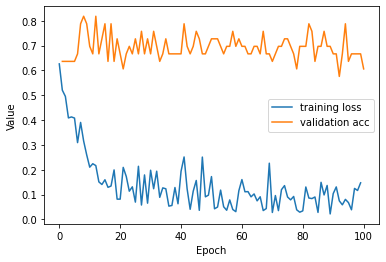

In [ ]:
plt.plot(epoch_loss_values, label="training loss")
val_epochs = np.linspace(
    1, max_epochs, np.floor(max_epochs / val_interval).astype(np.int32)
)
plt.plot(val_epochs, metric_values, label="validation acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Value")

# **GradCAM Visualization**

In [ ]:
# Reload the best network and display info
#model_3d =monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=num_class).to(device) # Check !!!!!

model_3d_resnet = monai.networks.nets.se_resnet50(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)
#model_3d_resnet50_32x4d = monai.networks.nets.se_resnext50_32x4d(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)
model_3d_resnet101_32x4d = monai.networks.nets.se_resnext101_32x4d(spatial_dims=3, in_channels=1, num_classes=num_class).to(device)


model_3d = MyModel()
model_3d.load_state_dict(
    torch.load("best_metric_model.pth")
)
model_3d.eval()

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

In [ ]:
model_3d.children # Check the structure of the network

<bound method Module.children of MyModel(
  (resnet): Sequential(
    (0): Sequential(
      (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (A): ReLU(inplace=True)
          )
        )
        (conv2): Convolution(
          (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="features.denseblock4.denselayer16.layers.relu2", fc_layers="class_layers.out")

#cam = monai.visualize.GradCAM(nn_module=model_3d, target_layers="layer3")
campp = monai.visualize.GradCAMpp(nn_module=model_3d.resnet, target_layers="1")

print("original feature shape", campp.feature_map_size([1, 1] + list(win_size), device))
print("upsampled feature shape", [1, 1] + list(win_size))


original feature shape torch.Size([1, 1, 28, 28, 4])
upsampled feature shape [1, 1, 112, 112, 16]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
file name: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P082.nii.gz
shape of the GradCAM++ heatmap w.r.t. the slice 8: (1, 1, 112, 112)
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
file name: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P045.nii.gz
shape of the GradCAM++ heatmap w.r.t. the slice 8: (1, 1, 112, 112)
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
file name: /content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped/Case_P005.nii.gz
shape of the GradCAM++ heatmap w.r.t. the slice 8: (1, 1, 112, 112)
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112,

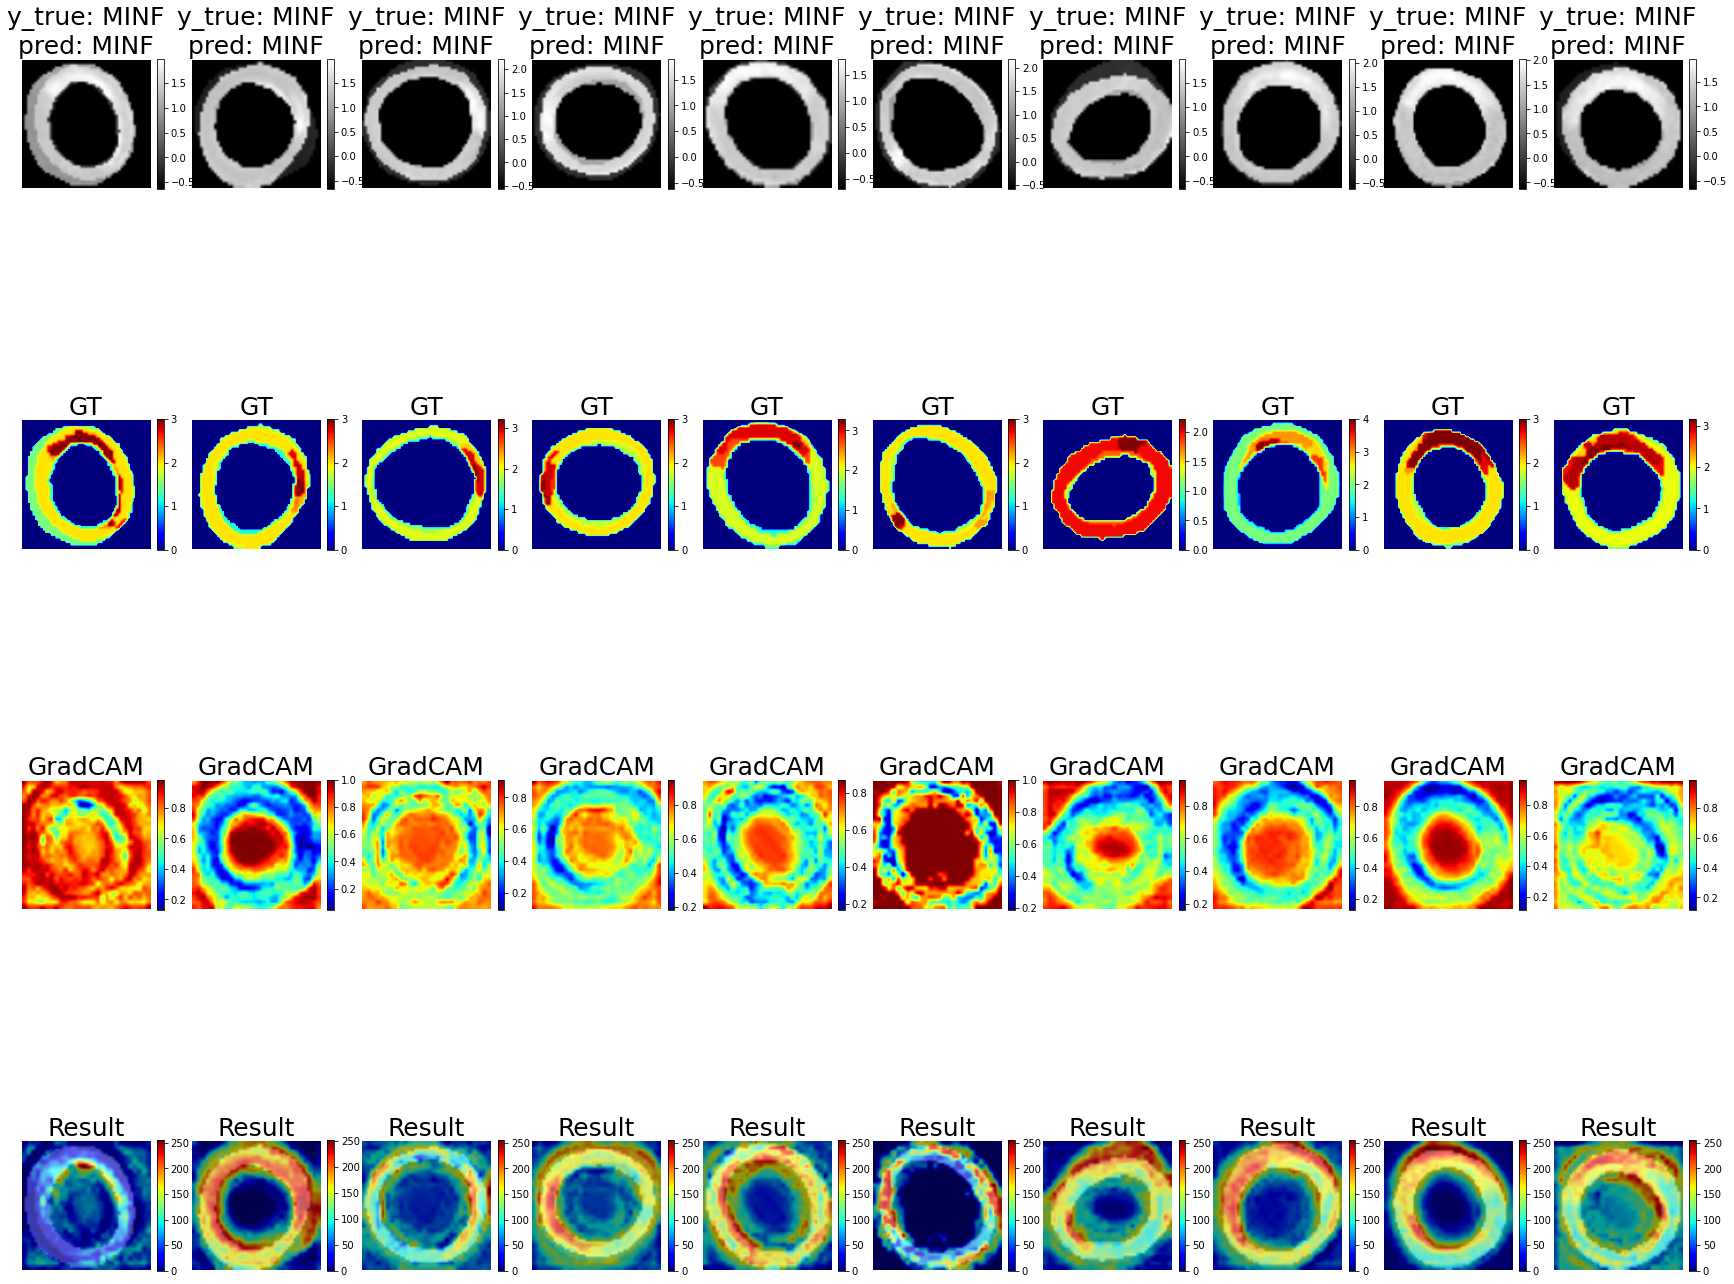

In [ ]:
# Visualize Results and Gradcam images - TODO SLICE ILE OYNA
train_transforms.set_random_state(42)
n_examples = 10
subplot_shape = [4, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(30,25), facecolor='white')
plt.subplots_adjust(hspace=0.3)
#items = np.random.choice(len(train_ds), size=len(train_ds)) #*
items = [44,12, 48, 39, 49,11, 20, 30, 40, 50, 60, 10, 34, 55, 42,32, 66]
example = 0
for item in items:
    
    data = train_ds[item]  # this fetches training data with random augmentations #*
 
    image, label, clc = data[0].to(device).unsqueeze(0), data[1], data[2]
    print(f"Shape of the selected image :  {image.shape} ")
    
    # Detirmine the slice to be visualized
    the_slice = image.shape[-1] // 2
    
    if label != 1 : # discard the Healthy and visualize only MINF
        continue

    filename =  train_ds.image_files[item]
    print(f"file name: {filename}")
    # Scar segmentation of the crresponding image
    seg_scar = filename[:-7]
    filename_seg_scar = seg_scar + "_gt_scar"+ ".nii.gz"
    seg_scar_transformed = visualize_transforms(filename_seg_scar)
    clc = torch.tensor(clc)
    clc = clc.to(device).unsqueeze(0)
    y_pred = model_3d(image, clc)
    pred_label = y_pred.argmax(1).item()
    img = image.detach().cpu().numpy()[..., the_slice]
    

    name = "y_true: "
    if label == 0: name += "Healthy"
    elif label == 1: name += "MINF"

    name += "\npred: "
    if pred_label == 0: name += "Healthy"
    elif pred_label == 1: name += "MINF"
    #thresholder = ThresholdIntensity(threshold=0.3)
    
    #name += f"\nlesion: {y_pred[0,1]:.3}"
    #name += f"\nnon-lesion: {y_pred[0,0]:.3}"
    
    # run CAM
    #cam_result = cam(x=image, class_idx=pred_label)
    
    #print(f"shape of the GradCAM heatmap: { cam_result.shape} " )

    #cam_result = cam_result[..., the_slice]
    #print(f"shape of the GradCAM heatmap w.r.t. the slice {the_slice}: {cam_result.shape}" )
    
    
    #run CAMpp
    campp_result = campp(x=image, class_idx=pred_label)
    
    
    
    #print(f"shape of the GradCAM++ heatmap: {campp_result.shape} " )
    campp_result = campp_result[..., the_slice]
   
    print(f"shape of the GradCAM++ heatmap w.r.t. the slice {the_slice}: {campp_result.shape}" )

    #cam_and_img = superimposed_image_def(cam_result, img, alpha = 0.4)
    campp_and_img = superimposed_image_def(campp_result, img, alpha = 0.4)

    scar_img = seg_scar_transformed[...,the_slice]
    scar_img = scar_img[0,:,:]

    for row, (im, title) in enumerate(zip(
       # [img, cam_result, occ_result],
       # [name, "CAM", "Occ. sens."],
        # [img, scar_img, campp_result, campp_and_img, cam_result, cam_and_img],
        # [name, "GT", "GradCAM++", "Result", "GradCAM", "Result"],
         [img, scar_img,campp_result, campp_and_img],
         [name, "GT", "GradCAM", "Result"],
    )):
        if (row == 0):
          cmap = 'gray'      
        else :
          cmap ='jet'
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()


        if row == 0 or row == 2 :
            im_show = ax.imshow(im[0,0,:,:], cmap=cmap)
        else: 
           im_show = ax.imshow(im, cmap=cmap) 

        ax.set_title(title, fontsize=25)
        ax.axis('off')

        fig.colorbar(im_show, fraction=0.046,ax=ax)            
            
    example += 1
    if example == n_examples:
        break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
shape of the GradCAM++ heatmap w.r.t. the slice 8: (1, 1, 112, 112)
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
shape of the GradCAM++ heatmap w.r.t. the slice 8: (1, 1, 112, 112)
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the selected image :  torch.Size([1, 1, 112, 112, 16]) 
Shape of the select

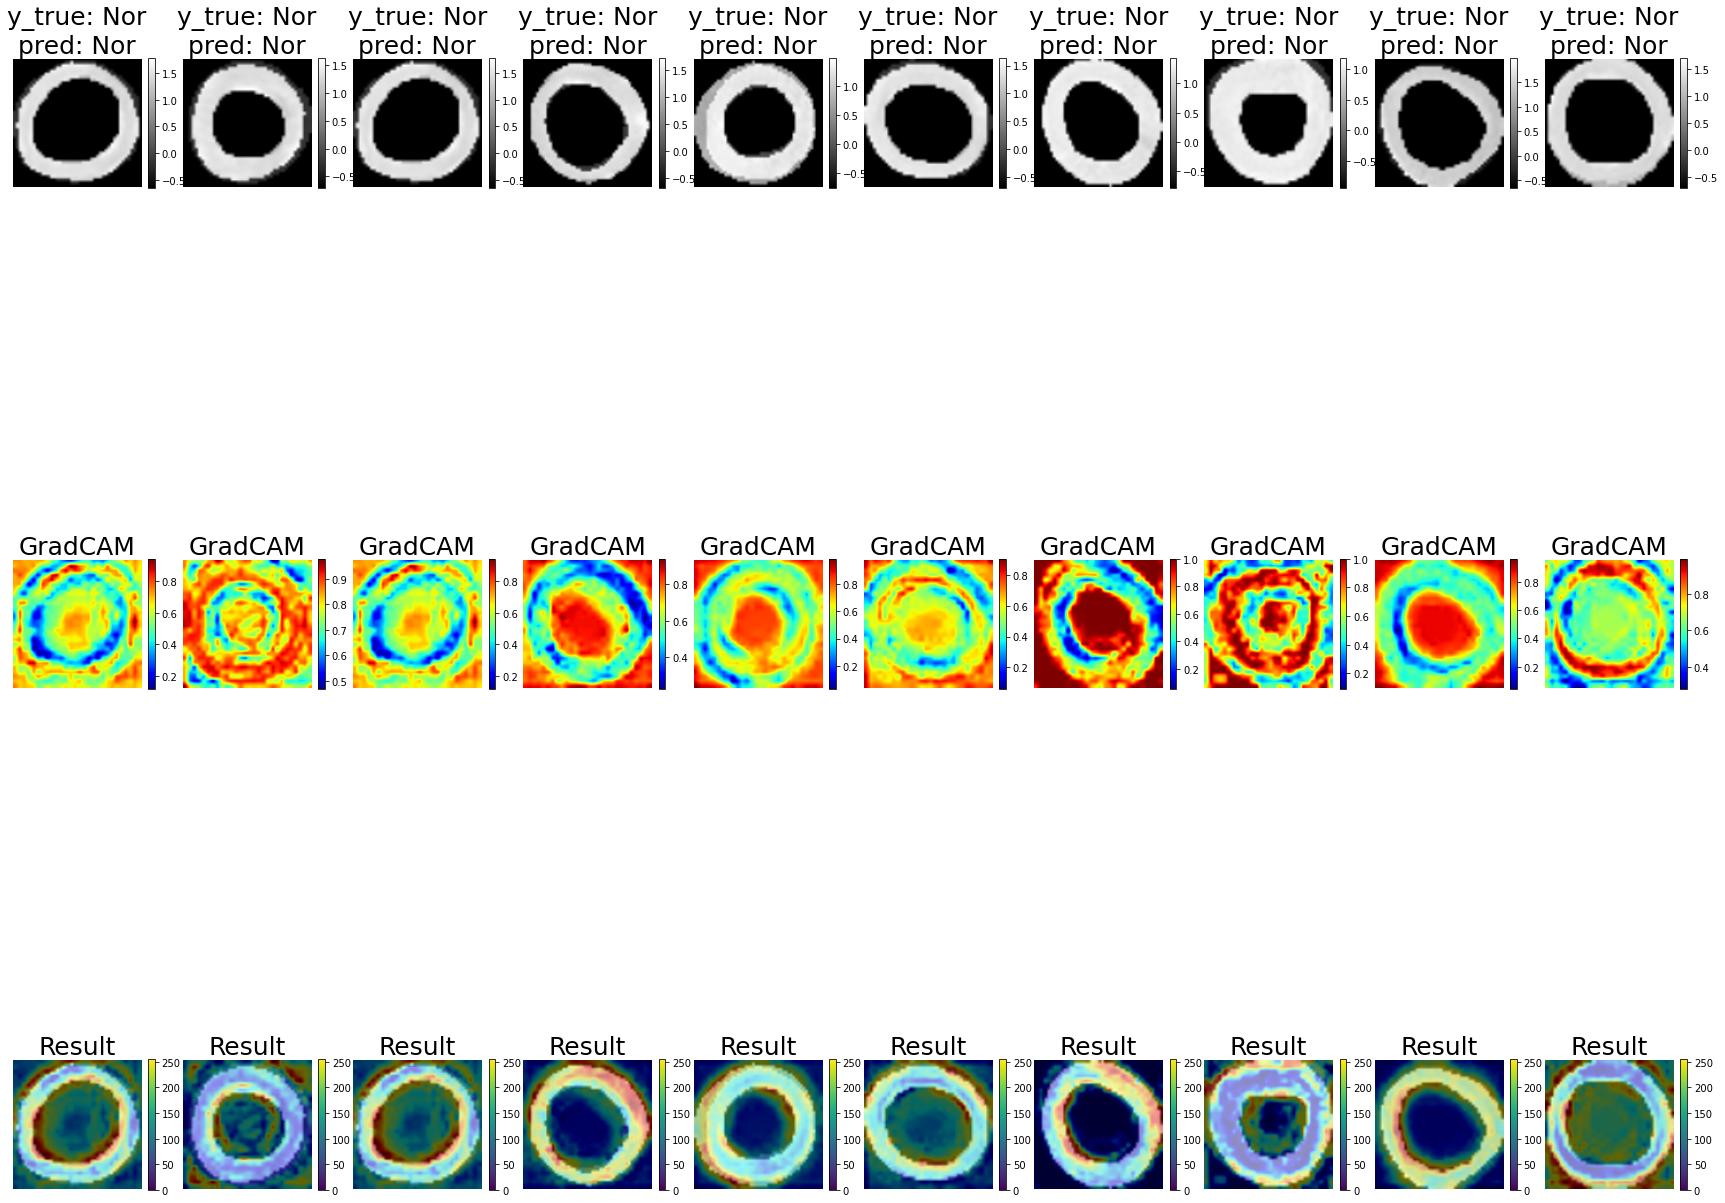

In [ ]:
# Visualize Results and Gradcam images - Change the slice to visualize
train_transforms.set_random_state(42)
n_examples = 10
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(30,25), facecolor='white')
plt.subplots_adjust(hspace=0.4)
#items = np.random.choice(len(train_ds), size=len(train_ds)) #*
#print(items)
items = [66,45, 23, 31, 22, 26,  1, 16, 32,  8, 42, 47, 38, 41, 25, 49, 24, 23, 12, 59,  6, 56,
 35, 44, 19, 64,  7, 15, 13, 14, 65, 31, 62, 50, 24, 57, 62, 61, 21,  48, 51, 41, 14, 53,
 59,  7, 52, 4,  5, 46, 54, 39, 51, 15, 12, 29, 18, 16, 62, 18, 54]
example = 0
for item in items:
    
    data = train_ds[item]  # this fetches training data with random augmentations #*
    image, label, clc_ = data[0].to(device).unsqueeze(0), data[1], data[2]

    print(f"Shape of the selected image :  {image.shape} ")
    # Detirmine the slice to be visualized
    the_slice = image.shape[-1] // 2
    
    clc_ = torch.tensor(clc_)
    clc_ = clc_.to(device).unsqueeze(0)

    y_pred = model_3d(image, clc_)
    pred_label = y_pred.argmax(1).item()

    if label != 0: # discard the MINF and visualize only healthy
        continue

        
    img = image.detach().cpu().numpy()[..., the_slice]
    
    name = "y_true: "
    if label == 0: name += "Nor"
    elif label == 1: name += "MINF"

    name += "\npred: "
    if pred_label == 0: name += "Nor"
    elif pred_label == 1: name += "MINF"
    
    
    #name += f"\nlesion: {y_pred[0,1]:.3}"
    #name += f"\nnon-lesion: {y_pred[0,0]:.3}"
    
    # run CAM
    #cam_result = cam(x=image, class_idx=None)
    #print(f"shape of the GradCAM heatmap: { cam_result.shape} " )

    #cam_result = cam_result[..., the_slice]
    #print(f"shape of the GradCAM heatmap w.r.t. the slice {the_slice}: {cam_result.shape}" )

    
    #run CAMpp
    campp_result = campp(x=image, class_idx=None)
    #print(f"shape of the GradCAM++ heatmap: {campp_result.shape} " )
    campp_result = campp_result[..., the_slice]
    print(f"shape of the GradCAM++ heatmap w.r.t. the slice {the_slice}: {campp_result.shape}" )

    #cam_and_img = superimposed_image_def(cam_result, img)
    campp_and_img = superimposed_image_def(campp_result, img)

    for row, (im, title) in enumerate(zip(
       # [img, cam_result, occ_result],
       # [name, "CAM", "Occ. sens."],
         [img, campp_result, campp_and_img],
         [name, "GradCAM", "Result"],
    )):
        cmap = 'gray' if row == 0 else 'jet'
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        if row == 2 :
            im_show = ax.imshow(im) 
        else:
            im_show = ax.imshow(im[0,0,:,:], cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis('off')

        fig.colorbar(im_show, fraction=0.046,ax=ax)            
            
    example += 1
    if example == n_examples:
        break